In [ ]:
pip install deeplabcut

In [ ]:
pip install --upgrade tensorflow==2.12.0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# VARIABLE DECLARATION


In [ ]:
# The path which includes all the raw files (Video, pointgrey timestamp file, ADC)
file_path = '/content/drive/My Drive/RGS14/'

# The date tag of the trial as string (For example: 2018-07-30T11_24_12)
date_serial = '2018-07-30T11_24_12'

# The number of the ADC file as string (It is indicated in the file name after the "ADC" - For instance: 100-ADC *1* _0.continuous)
ADC = '1'

# The name of the project folder (The DeeLabCut project name)
ProjectFolderName = 'newtest-soroush-2023-07-11'

# VideoType of the trial waiting for analysis
VideoType = 'avi'

# Path of the config.yaml file (It *SHOULD* be directly inside the main project folder)
path_config_file = '/content/drive/My Drive/' + ProjectFolderName + '/config.yaml'

# Path of the trial files after timestamp creating (Best to be in a seperate folder without the raw files)
path_trial = '/content/drive/My Drive/RGS14/trimmed/'

# The name of the scorer (the trained model name)
DLCscorer = 'DLC_resnet50_newtestJul11shuffle1_150000'

# For *Synchronization* - bool value (True if you want to analyze and cut the video)
cut_analyze = False

# For *Analysis and Post-Processing* - bool value (True if you need to create CSV files rather than h5)
save_csv = False

# For *Analysis and Post-Processing* - bool value (True if you want to create a labeled video)
create_labeled = False

# For *Analysis and Post-Processing* - bool value (True if you want to create plots of the trajectory, likelihood, x and y coordinates)
create_plots = False

# For *Analysis and Post-Processing* - bool value (True if you want to create the skeleton files)
analyze_skeleton = False

# For *Analysis and Post-Processing* - bool value (True if you want to check time spent in each *4 CORNERS*)
corner_inspection = True
x = 140 #The middle point of the arena (To divide the arena into 4 corners)
y = 160

# For *Analysis and Post-Processing* - bool value (True if you want to check the head direction)
head_dir = False

# For *Analysis and Post-Processing* - bool value (True if you want to create an occupancy map)
occupancy_map = True

# For *Analysis and Post-Processing* - bool value (True if you want to check the velocity of the rat)
calculate_speed = False


# other code

In [ ]:
import os, sys, re
'''
def downsample_ADC_led(DF_ADC_samples):
  DF_ADC_samples.rename(columns={0 : 'value'}, inplace=True)
  DF_ADC_samples['state'] = 0

  # ADC Amplitude is originally between 0 to 5, so we change it to binary states
  DF_ADC_samples.loc[DF_ADC_samples.value.between(0,1), 'state'] = 0
  DF_ADC_samples.loc[DF_ADC_samples.value.between(1,5), 'state'] = 1
  group_size = 1000   # Factor of downsampling

  # Count the number of ones in windows of 200 frames
  DF_ADC_samples['state'] = DF_ADC_samples['state'].rolling(window = 200).sum()
  max_num = DF_ADC_samples['state'].max()
  lst = []

  # Create a new smaller dataframe using the bigger one
  for i in range(int(len(DF_ADC_samples) / group_size)):
    lst.append(DF_ADC_samples['state'].iloc[i * group_size])

  blabla = pd.DataFrame(lst)
  blabla = blabla.dropna()
  # Normalization [0,1]
  blabla = blabla / blabla.max()

  return blabla

'''

def downsample_ADC_led(DF_ADC_samples):
  DF_ADC_samples.rename(columns={0 : 'value'}, inplace=True)
  DF_ADC_samples['value'] = DF_ADC_samples['value'].rolling(window = 15000).mean()
  ave = DF_ADC_samples['value'].mean()
  DF_ADC_samples['state'] = 0
  DF_ADC_samples.loc[DF_ADC_samples.value.between(0,ave), 'state'] = 0
  DF_ADC_samples.loc[DF_ADC_samples.value.between(ave,5), 'state'] = 1
  DF_ADC_samples['state'] = DF_ADC_samples['state'].rolling(window = 25000).mean()
  ave = DF_ADC_samples['state'].mean()
  DF_ADC_samples.loc[DF_ADC_samples.state.between(0,ave), 'state'] = 0
  DF_ADC_samples.loc[DF_ADC_samples.state.between(ave,5), 'state'] = 1


  group_size = 1000
  lst = [DF_ADC_samples.iloc[i:i+group_size] for i in range(0,len(DF_ADC_samples)-group_size+1,group_size)]

  bla = []
  for df in lst:
    m = df["state"].iloc[-1]
    bla.append(m)

  blabla = pd.DataFrame(bla)
  return blabla

'''
#ORIGINAL DOWNSAMPLE ADC
def downsample_ADC_led(DF_ADC_samples):
  DF_ADC_samples.rename(columns={0 : 'value'}, inplace=True)
  DF_ADC_samples['state'] = 0
  DF_ADC_samples.loc[DF_ADC_samples.value.between(0,1), 'state'] = 0
  DF_ADC_samples.loc[DF_ADC_samples.value.between(1,5), 'state'] = 1

  group_size = 1000
  lst = [DF_ADC_samples.iloc[i:i+group_size] for i in range(0,len(DF_ADC_samples)-group_size+1,group_size)]

  bla = []
  for df in lst:
    m = df["state"].iloc[-1]
    bla.append(m)

  blabla = pd.DataFrame(bla)
  return blabla
'''

def downsample_ADC(DF_ADC_samples):

  #DF_ADC_samples.rename(columns={0 : 'value'}, inplace=True)
  print(DF_ADC_samples.head())

  group_size = 1
  lst = [DF_ADC_samples.iloc[i:i+group_size] for i in range(0,len(DF_ADC_samples)-group_size+1,group_size)]

  bla = []
  for df in lst:
    m = df['comb'].iloc[-1]
    bla.append(m)

  blabla = pd.DataFrame(bla)
  return blabla




def frames_to_timecode(frames,framerate=30):
      """ Makes a timecode in the format HH:MM:SS:MS using framenumber and rate

      Keyword arguments:
      frames -- int of the frame number you want to convert to a time
      framerate -- int ofthe frame rate of the camera (default 30)
      """
      return'{0:02d}:{1:02d}:{2:02d}:{3:02d}'.format(int(frames / (3600*framerate)),
                                                      int(frames / (60*framerate) % 60),
                                                      int(frames / framerate % 60),
                                                      int(frames % framerate))
      return b

# returns list with file names (0 = frameNumbers, 1 = timestamps, 2 = ledstatus, 3 = video)
def make_pg_files(date_serial):
      """ Makes a dictionary with the files of this date serial,
          dictionary looks like the following:
          {0 = frameNumbers, 1 = timestamps, 2 = ledstatus, 3 = video}

        Keyword arguments:
        date_serial -- string with date serial given in a set of pointgrey files
                      example: file name = PointGreyTimestamps2020-04-27T10_40_02.csv
                                the date serial would be "2020-04-27T10_40_02"

      """
      camera = 'PointGrey'
      types_files = ['Framenumber','Timestamps', 'LEDStatus']
      f_type = '.csv'
      v_type = '.avi'
      files = []
      for t in types_files:
        n = camera+t+date_serial+f_type
        files.append(n)
      files.append(camera+'Video'+date_serial+'downsampled'+v_type)
      return files


def get_seconds(b_list):
      """ calculates the seconds from a list of timestamps in format HH:MM:SS

      Keyword arguments:
      b_list -- list of timestamp pairs looks like the following:
                [01:55:34-01:58:56,..]

    """
      times_list = []
      for l in b_list:
          s_list = []
          for t in l:
              hh, mm, ss, ms = t.split(':')
              s = int(hh) * 3600 + int(mm) * 60 + int(ss)
              s_list.append(s)
          time = str(s_list[0]) + '-' + str(s_list[1])
          times_list.append(time)
      print(times_list)
      return times_list

def load_data_into_dataframe(data):
      """ Makes a pandas dataframe for the data and another for the timestamps
          in the open ephys data dictionary
          Keyword arguments:
          data -- Dictionary gathered from the open ephys code
          after loading the ADC files
      """
      samples = np.array(data['data'])
      timestamps = np.array(data['timestamps'])
      DF_samples = pd.DataFrame(samples)
      DF_timestamps = pd.DataFrame(timestamps)
      # print(DF_samples.head())
      # print(DF_timestamps.head())
      # print(len(DF_samples))
      # print(len(DF_timestamps))
      return DF_samples, DF_timestamps


def converttime(time):
      """ Takes an array of Pointgrey timestamps and decodes it into seconds
      Keyword arguments:
      author: goncaloclopes
      time -- array of pointgrey timestamps
      """
      #offset = time & 0xFFF
      time = time.to_numpy()
      cycle1 = (time >> 12) & 0x1FFF
      cycle2 = (time >> 25) & 0x7F
      seconds = cycle2 + cycle1 / 8000.
      return seconds


def converttimex(time):
      """ Takes an array of Pointgrey timestamps and decodes it into seconds
      Keyword arguments:
      author: goncaloclopes
      time -- array of pointgrey timestamps
      """
      #offset = time & 0xFFF
      cycle1 = (time >> 12) & 0x1FFF
      cycle2 = (time >> 25) & 0x7F
      seconds = cycle2 + cycle1 / 8000.
      print(seconds)
      return seconds

converttimex(1689784547)
def uncycle(time):
      """ Takes an array of converted Pointgrey timestamps
      and uncycles them so it correlates to the actual time
      author: goncaloclopes
      Keyword arguments:
      time -- array of pointgrey decoded timestamps
      """
      cycles = np.insert(np.diff(time) < 0, 0, False)
      cycleindex = np.cumsum(cycles)
      return time + cycleindex * 128

def convert_and_uncycle_timestamps(df):
    """ Takes a dataframe of Pointgrey timestamps
      and converts and uncycles them so it correlates to the actual time
      Keyword arguments:
      df -- Dataframe of pointgrey timestamps
    """
    df = df.astype({col: 'int32' for col in df.select_dtypes('int64').columns})
    modDfObj = df.apply(converttime)
    uncycledDF = modDfObj.apply(uncycle)
    return uncycledDF

def dividething(n):
    """ divide by 30k to make up for sampling rate
    """
    n = n/30000
    return n

def calculate_pixel_size(dpi):
  """ calculate the size of a pixel based on the dpi of a picture
  """
  #dpi is the pixel density or dots per inch.
  #96 dpi means there are 96 pixels per inch.
  #1 inch is equal to 25.4 millimeters.
  inch = 25.4
  pixel_size= dpi/inch
  return pixel_size

def cut(video_file_path, start_time, end_time):
  """ cuts the video using ffmpeg using the start and end time and the video
  Keyword arguments:
  video_file_path -- full path to the video
  start_time -- string of time in HH:MM:SS:ff format
  end_time -- string of time in HH:MM:SS:ff format
  """
  output_file_path = re.search("^[\/].+\/", video_file_path)
  output_file_path_raw = output_file_path.group(0)
  delsplit = re.search("\/(?:.(?!\/))+$", video_file_path)
  filename = re.sub("^[\/]", "", delsplit.group(0))
  filename_raw = re.sub(".{4}$", "", filename)
  file_extension = re.search(".{3}$", filename)
  file_extension_raw = file_extension.group(0)

  os.environ['inputFile'] = video_file_path
  os.environ['outputPath'] = output_file_path_raw
  os.environ['startTime'] = start_time
  os.environ['endTime'] = end_time
  os.environ['fileName'] = filename_raw
  os.environ['fileExtension'] = file_extension_raw

  !ffmpeg -hide_banner -i "$inputFile" -ss "$startTime" -to "$endTime" -c copy "$outputPath"/"$fileName"-TRIM."$fileExtension"

50.368125


In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Sun Aug  3 15:18:38 2014
@author: Dan Denman and Josh Siegle
Loads .continuous, .events, and .spikes files saved from the Open Ephys GUI
Usage:
    import OpenEphys
    data = OpenEphys.load(pathToFile) # returns a dict with data, timestamps, etc.
"""

import os
import numpy as np
import scipy.signal
import scipy.io
import time
import struct
from copy import deepcopy

# constants
NUM_HEADER_BYTES = 1024
SAMPLES_PER_RECORD = 1024
BYTES_PER_SAMPLE = 2
RECORD_SIZE = 4 + 8 + SAMPLES_PER_RECORD * BYTES_PER_SAMPLE + 10 # size of each continuous record in bytes
RECORD_MARKER = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 255])

# constants for pre-allocating matrices:
MAX_NUMBER_OF_SPIKES = int(1e6)
MAX_NUMBER_OF_RECORDS = int(1e6)
MAX_NUMBER_OF_EVENTS = int(1e6)

def load(filepath, dtype = float):

    # redirects to code for individual file types
    if 'continuous' in filepath:
        data = loadContinuous(filepath, dtype)
    elif 'spikes' in filepath:
        data = loadSpikes(filepath)
    elif 'events' in filepath:
        data = loadEvents(filepath)
    else:
        raise Exception("Not a recognized file type. Please input a .continuous, .spikes, or .events file")

    return data

def loadFolder(folderpath, dtype = float, **kwargs):

    # load all continuous files in a folder

    data = { }

    # load all continuous files in a folder
    if 'channels' in kwargs.keys():
        filelist = ['100_CH'+x+'.continuous' for x in map(str,kwargs['channels'])]
    else:
        filelist = os.listdir(folderpath)

    t0 = time.time()
    numFiles = 0

    for i, f in enumerate(filelist):
        if '.continuous' in f:
            data[f.replace('.continuous','')] = loadContinuous(os.path.join(folderpath, f), dtype = dtype)
            numFiles += 1

    print(''.join(('Avg. Load Time: ', str((time.time() - t0)/numFiles),' sec')))
    print(''.join(('Total Load Time: ', str((time.time() - t0)),' sec')))

    return data

def loadFolderToArray(folderpath, channels = 'all', chprefix = 'CH',
                      dtype = float, session = '0', source = '100'):
    '''Load continuous files in specified folder to a single numpy array. By default all
    CH continous files are loaded in numerical order, ordering can be specified with
    optional channels argument which should be a list of channel numbers.'''

    if channels == 'all':
        channels = _get_sorted_channels(folderpath, chprefix, session, source)

    if session == '0':
        filelist = [source + '_'+chprefix + x + '.continuous' for x in map(str,channels)]
    else:
        filelist = [source + '_'+chprefix + x + '_' + session + '.continuous' for x in map(str,channels)]

    t0 = time.time()
    numFiles = 1

    channel_1_data = loadContinuous(os.path.join(folderpath, filelist[0]), dtype)['data']

    n_samples  = len(channel_1_data)
    n_channels = len(filelist)

    data_array = np.zeros([n_samples, n_channels], dtype)
    data_array[:,0] = channel_1_data

    for i, f in enumerate(filelist[1:]):
            data_array[:, i + 1] = loadContinuous(os.path.join(folderpath, f), dtype)['data']
            numFiles += 1

    print(''.join(('Avg. Load Time: ', str((time.time() - t0)/numFiles),' sec')))
    print(''.join(('Total Load Time: ', str((time.time() - t0)),' sec')))

    return data_array

def loadContinuous(filepath, dtype = float):

    assert dtype in (float, np.int16), \
      'Invalid data type specified for loadContinous, valid types are float and np.int16'

    print("Loading continuous data...")

    ch = { }

    #read in the data
    f = open(filepath,'rb')

    fileLength = os.fstat(f.fileno()).st_size

    # calculate number of samples
    recordBytes = fileLength - NUM_HEADER_BYTES
    if  recordBytes % RECORD_SIZE != 0:
        raise Exception("File size is not consistent with a continuous file: may be corrupt")
    nrec = recordBytes // RECORD_SIZE
    nsamp = nrec * SAMPLES_PER_RECORD
    # pre-allocate samples
    samples = np.zeros(nsamp, dtype)
    timestamps = np.zeros(nrec)
    recordingNumbers = np.zeros(nrec)
    indices = np.arange(0, nsamp + 1, SAMPLES_PER_RECORD, np.dtype(np.int64))

    header = readHeader(f)

    recIndices = np.arange(0, nrec)

    for recordNumber in recIndices:

        timestamps[recordNumber] = np.fromfile(f,np.dtype('<i8'),1) # little-endian 64-bit signed integer
        N = np.fromfile(f,np.dtype('<u2'),1)[0] # little-endian 16-bit unsigned integer

        #print index

        if N != SAMPLES_PER_RECORD:
            raise Exception('Found corrupted record in block ' + str(recordNumber))

        recordingNumbers[recordNumber] = (np.fromfile(f,np.dtype('>u2'),1)) # big-endian 16-bit unsigned integer

        if dtype == float: # Convert data to float array and convert bits to voltage.
            data = np.fromfile(f,np.dtype('>i2'),N) * float(header['bitVolts']) # big-endian 16-bit signed integer, multiplied by bitVolts
        else:  # Keep data in signed 16 bit integer format.
            data = np.fromfile(f,np.dtype('>i2'),N)  # big-endian 16-bit signed integer
        samples[indices[recordNumber]:indices[recordNumber+1]] = data

        marker = f.read(10) # dump

    #print recordNumber
    #print index

    ch['header'] = header
    ch['timestamps'] = timestamps
    ch['data'] = samples  # OR use downsample(samples,1), to save space
    ch['recordingNumber'] = recordingNumbers
    f.close()
    return ch

def loadSpikes(filepath):

    '''
    Loads spike waveforms and timestamps from filepath (should be .spikes file)
    '''

    data = { }

    print('loading spikes...')

    f = open(filepath, 'rb')
    header = readHeader(f)

    if float(header[' version']) < 0.4:
        raise Exception('Loader is only compatible with .spikes files with version 0.4 or higher')

    data['header'] = header
    numChannels = int(header['num_channels'])
    numSamples = 40 # **NOT CURRENTLY WRITTEN TO HEADER**

    spikes = np.zeros((MAX_NUMBER_OF_SPIKES, numSamples, numChannels))
    timestamps = np.zeros(MAX_NUMBER_OF_SPIKES)
    source = np.zeros(MAX_NUMBER_OF_SPIKES)
    gain = np.zeros((MAX_NUMBER_OF_SPIKES, numChannels))
    thresh = np.zeros((MAX_NUMBER_OF_SPIKES, numChannels))
    sortedId = np.zeros((MAX_NUMBER_OF_SPIKES, numChannels))
    recNum = np.zeros(MAX_NUMBER_OF_SPIKES)

    currentSpike = 0

    while f.tell() < os.fstat(f.fileno()).st_size:
        eventType = np.fromfile(f, np.dtype('<u1'),1) #always equal to 4, discard
        timestamps[currentSpike] = np.fromfile(f, np.dtype('<i8'), 1)
        software_timestamp = np.fromfile(f, np.dtype('<i8'), 1)
        source[currentSpike] = np.fromfile(f, np.dtype('<u2'), 1)
        numChannels = np.fromfile(f, np.dtype('<u2'), 1)[0]
        numSamples = np.fromfile(f, np.dtype('<u2'), 1)[0]
        sortedId[currentSpike] = np.fromfile(f, np.dtype('<u2'),1)
        electrodeId = np.fromfile(f, np.dtype('<u2'),1)
        channel = np.fromfile(f, np.dtype('<u2'),1)
        color = np.fromfile(f, np.dtype('<u1'), 3)
        pcProj = np.fromfile(f, np.float32, 2)
        sampleFreq = np.fromfile(f, np.dtype('<u2'),1)

        waveforms = np.fromfile(f, np.dtype('<u2'), numChannels*numSamples)
        gain[currentSpike,:] = np.fromfile(f, np.float32, numChannels)
        thresh[currentSpike,:] = np.fromfile(f, np.dtype('<u2'), numChannels)
        recNum[currentSpike] = np.fromfile(f, np.dtype('<u2'), 1)

        waveforms_reshaped = np.reshape(waveforms, (numChannels, numSamples))
        waveforms_reshaped = waveforms_reshaped.astype(float)
        waveforms_uv = waveforms_reshaped

        for ch in range(numChannels):
            waveforms_uv[ch, :] -= 32768
            waveforms_uv[ch, :] /= gain[currentSpike, ch]*1000

        spikes[currentSpike] = waveforms_uv.T

        currentSpike += 1

    data['spikes'] = spikes[:currentSpike,:,:]
    data['timestamps'] = timestamps[:currentSpike]
    data['source'] = source[:currentSpike]
    data['gain'] = gain[:currentSpike,:]
    data['thresh'] = thresh[:currentSpike,:]
    data['recordingNumber'] = recNum[:currentSpike]
    data['sortedId'] = sortedId[:currentSpike]

    return data


def loadEvents(filepath):

    data = { }

    print('loading events...')

    f = open(filepath,'rb')
    header = readHeader(f)

    if float(header[' version']) < 0.4:
        raise Exception('Loader is only compatible with .events files with version 0.4 or higher')

    data['header'] = header

    index = -1

    channel = np.zeros(MAX_NUMBER_OF_EVENTS)
    timestamps = np.zeros(MAX_NUMBER_OF_EVENTS)
    sampleNum = np.zeros(MAX_NUMBER_OF_EVENTS)
    nodeId = np.zeros(MAX_NUMBER_OF_EVENTS)
    eventType = np.zeros(MAX_NUMBER_OF_EVENTS)
    eventId = np.zeros(MAX_NUMBER_OF_EVENTS)
    recordingNumber = np.zeros(MAX_NUMBER_OF_EVENTS)

    while f.tell() < os.fstat(f.fileno()).st_size:

        index += 1

        timestamps[index] = np.fromfile(f, np.dtype('<i8'), 1)
        sampleNum[index] = np.fromfile(f, np.dtype('<i2'), 1)
        eventType[index] = np.fromfile(f, np.dtype('<u1'), 1)
        nodeId[index] = np.fromfile(f, np.dtype('<u1'), 1)
        eventId[index] = np.fromfile(f, np.dtype('<u1'), 1)
        channel[index] = np.fromfile(f, np.dtype('<u1'), 1)
        recordingNumber[index] = np.fromfile(f, np.dtype('<u2'), 1)

    data['channel'] = channel[:index]
    data['timestamps'] = timestamps[:index]
    data['eventType'] = eventType[:index]
    data['nodeId'] = nodeId[:index]
    data['eventId'] = eventId[:index]
    data['recordingNumber'] = recordingNumber[:index]
    data['sampleNum'] = sampleNum[:index]

    return data

def readHeader(f):
    header = { }
    h = f.read(1024).decode().replace('\n','').replace('header.','')
    for i,item in enumerate(h.split(';')):
        if '=' in item:
            header[item.split(' = ')[0]] = item.split(' = ')[1]
    return header

def downsample(trace,down):
    downsampled = scipy.signal.resample(trace,np.shape(trace)[0]/down)
    return downsampled

def pack(folderpath,source='100',**kwargs):
#convert single channel open ephys channels to a .dat file for compatibility with the KlustaSuite, Neuroscope and Klusters
#should not be necessary for versions of open ephys which write data into HDF5 format.
#loads .continuous files in the specified folder and saves a .DAT in that folder
#optional arguments:
#   source: string name of the source that openephys uses as the prefix. is usually 100, if the headstage is the first source added, but can specify something different
#
#   data: pre-loaded data to be packed into a .DAT
#   dref: int specifying a channel # to use as a digital reference. is subtracted from all channels.
#   order: the order in which the .continuos files are packed into the .DAT. should be a list of .continious channel numbers. length must equal total channels.
#   suffix: appended to .DAT filename, which is openephys.DAT if no suffix provided.

    #load the openephys data into memory
    if 'data' not in kwargs.keys():
        if 'channels' not in kwargs.keys():
            data = loadFolder(folderpath, dtype = np.int16)
        else:
            data = loadFolder(folderpath, dtype = np.int16, channels=kwargs['channels'])
    else:
        data = kwargs['data']
    #if specified, do the digital referencing
    if 'dref' in kwargs.keys():
        ref =load(os.path.join(folderpath,''.join((source,'_CH',str(kwargs['dref']),'.continuous'))))
        for i,channel in enumerate(data.keys()):
            data[channel]['data'] = data[channel]['data'] - ref['data']
    #specify the order the channels are written in
    if 'order' in kwargs.keys():
        order = kwargs['order']
    else:
        order = list(data)
    #add a suffix, if one was specified
    if 'suffix' in kwargs.keys():
        suffix=kwargs['suffix']
    else:
        suffix=''

    #make a file to write the data back out into .dat format
    outpath = os.path.join(folderpath,''.join(('openephys',suffix,'.dat')))
    out = open(outpath,'wb')

    #go through the data and write it out in the .dat format
    #.dat format specified here: http://neuroscope.sourceforge.net/UserManual/data-files.html
    channelOrder = []
    print(''.join(('...saving .dat to ',outpath,'...')))
    random_datakey = next(iter(data))
    bar = ProgressBar(len(data[random_datakey]['data']))
    for i in range(len(data[random_datakey]['data'])):
        for j in range(len(order)):
            if source in random_datakey:
                ch = data[order[j]]['data']
            else:
                ch = data[''.join(('CH',str(order[j]).replace('CH','')))]['data']
            out.write(struct.pack('h',ch[i]))#signed 16-bit integer
            #figure out which order this thing packed the channels in. only do this once.
            if i == 0:
                channelOrder.append(order[j])
        #update how mucb we have list
        if i%(len(data[random_datakey]['data'])/100)==0:
            bar.animate(i)
    out.close()
    print(''.join(('order: ',str(channelOrder))))
    print(''.join(('.dat saved to ',outpath)))

#**********************************************************
# progress bar class used to show progress of pack()
    #stolen from some post on stack overflow
import sys
try:
    from IPython.display import clear_output
    have_ipython = True
except ImportError:
    have_ipython = False
class ProgressBar:
    def __init__(self, iterations):
        self.iterations = iterations
        self.prog_bar = '[]'
        self.fill_char = '*'
        self.width = 40
        self.__update_amount(0)
        if have_ipython:
            self.animate = self.animate_ipython
        else:
            self.animate = self.animate_noipython

    def animate_ipython(self, iter):
        print('\r', self,)
        sys.stdout.flush()
        self.update_iteration(iter + 1)

    def update_iteration(self, elapsed_iter):
        self.__update_amount((elapsed_iter / float(self.iterations)) * 100.0)
        self.prog_bar += '  %d of %s complete' % (elapsed_iter, self.iterations)

    def __update_amount(self, new_amount):
        percent_done = int(round((new_amount / 100.0) * 100.0))
        all_full = self.width - 2
        num_hashes = int(round((percent_done / 100.0) * all_full))
        self.prog_bar = '[' + self.fill_char * num_hashes + ' ' * (all_full - num_hashes) + ']'
        pct_place = (len(self.prog_bar) // 2) - len(str(percent_done))
        pct_string = '%d%%' % percent_done
        self.prog_bar = self.prog_bar[0:pct_place] + \
            (pct_string + self.prog_bar[pct_place + len(pct_string):])

    def __str__(self):
        return str(self.prog_bar)
#*************************************************************

def pack_2(folderpath, filename = '', channels = 'all', chprefix = 'CH',
           dref = None, session = '0', source = '100'):

    '''Alternative version of pack which uses numpy's tofile function to write data.
    pack_2 is much faster than pack and avoids quantization noise incurred in pack due
    to conversion of data to float voltages during loadContinous followed by rounding
    back to integers for packing.
    filename: Name of the output file. By default, it follows the same layout of continuous files,
              but without the channel number, for example, '100_CHs_3.dat' or '100_ADCs.dat'.
    channels:  List of channel numbers specifying order in which channels are packed. By default
               all CH continous files are packed in numerical order.
    chprefix:  String name that defines if channels from headstage, auxiliary or ADC inputs
               will be loaded.
    dref:  Digital referencing - either supply a channel number or 'ave' to reference to the
           average of packed channels.
    source: String name of the source that openephys uses as the prefix. It is usually 100,
            if the headstage is the first source added, but can specify something different.
    '''

    data_array = loadFolderToArray(folderpath, channels, chprefix, np.int16, session, source)

    if dref:
        if dref == 'ave':
            print('Digital referencing to average of all channels.')
            reference = np.mean(data_array,1)
        else:
            print('Digital referencing to channel ' + str(dref))
            if channels == 'all':
                channels = _get_sorted_channels(folderpath, chprefix, session, source)
            reference = deepcopy(data_array[:,channels.index(dref)])
        for i in range(data_array.shape[1]):
            data_array[:,i] = data_array[:,i] - reference

    if session == '0': session = ''
    else: session = '_'+session

    if not filename: filename = source + '_' + chprefix + 's' + session + '.dat'
    print('Packing data to file: ' + filename)
    data_array.tofile(os.path.join(folderpath,filename))


def _get_sorted_channels(folderpath, chprefix='CH', session='0', source='100'):
    Files = [f for f in os.listdir(folderpath) if '.continuous' in f
                                               and '_'+chprefix in f
                                               and source in f]

    if session == '0':
        Files = [f for f in Files if len(f.split('_')) == 2]
        Chs = sorted([int(f.split('_'+chprefix)[1].split('.')[0]) for f in Files])
    else:
        Files = [f for f in Files if len(f.split('_')) == 3
                                  and f.split('.')[0].split('_')[2] == session]

        Chs = sorted([int(f.split('_'+chprefix)[1].split('_')[0]) for f in Files])
    return(Chs)



In [ ]:
import matplotlib.pyplot as plt # matplot lib is the premiere plotting lib for Python: https://matplotlib.org/
import numpy as np # numpy is the premiere signal handling library for Python: http://www.numpy.org/
import scipy as sp # for signal processing
from scipy import signal
from scipy.spatial import distance
import IPython.display as ipd
import librosa
import random
import math

# Function to pad zeros to the right of a signal to match a specified length
def pad_zeros_right(s, padding_length):
    # https://numpy.org/doc/1.18/reference/generated/numpy.pad.html
    return np.pad(s, (0, padding_length), mode = 'constant', constant_values=0)

# Function to pad mean of a signal to the right of it to match a specified length
def pad_mean_right(s, padding_length):
    # https://numpy.org/doc/1.18/reference/generated/numpy.pad.html
    return np.pad(s, (0, padding_length), mode = 'mean')

def pad_ones_right(s, padding_length):
    # https://numpy.org/doc/1.18/reference/generated/numpy.pad.html
    return np.pad(s, (0, padding_length), mode = 'constant', constant_values=1)

def pad_nan_right(s, padding_length):
    return np.pad(s, (0, padding_length), mode = 'constant', constant_values=np.nan)


# def compare_and_plot_signals(a, b, distance_function = distance.euclidean, alignment_function = None):
# Function to plot two signals (a and b) with same length after aligning them if they are not of same length
# The function performs cross-correlation of two signals and plots them
def plot_signals_with_alignment(a, b, pad_function = None):
    if(len(a) != len(b) and pad_function is None):
        raise Exception(f"Signal 'a' and 'b' must be the same size; len(a)={len(a)} and len(b)={len(b)} or pad_function must not be None")
    elif(len(a) != len(b) and pad_function is not None):
        if(len(a) < len(b)):
            a = pad_function(a, len(b) - len(a))
        else:
            b = pad_function(b, len(a) - len(b))
 # Checking if the signals a and b are of same length, if not pad zeros or mean to the right
    # to make them of same length


     # Perform cross-correlation of the two signals
    correlate_result = np.correlate(a, b, 'full')
    shift_positions = np.arange(-len(a) + 1, len(b))

# Print length of the two signals and cross-correlation result
    print("len(a)", len(a), "len(b)", len(b), "len(correlate_result)", len(correlate_result))

  # Plotting the signals and the cross-correlation results in separate subplots
    fig, axes = plt.subplots(5, 1, figsize=(10, 18))

# Plotting the two signals
    axes[0].plot(a, alpha=0.7, label="a", marker="o")
    axes[0].plot(b, alpha=0.7, label="b", marker="D")
    axes[0].legend()
    axes[0].set_title("Raw Signals 'a' and 'b'")

    #In the first subplot, we're plotting the original input signals a and b as they are.

    if len(shift_positions) < 20:
        # useful for debugging and showing correlation results
        print(shift_positions)
        print(correlate_result)

# Finding best match of cross-correlation and the corresponding shift amount

    best_correlation_index = np.argmax(correlate_result)
    shift_amount_debug = shift_positions[best_correlation_index]
    shift_amount = (-len(a) + 1) + best_correlation_index
    #finding the index of the maximum value in the cross-correlation result,
    #which corresponds to the best shift amount between a and b to achieve the highest correlation. The actual shift
    #amount is calculated by subtracting the length of a from this index (plus one).
    print("best_correlation_index", best_correlation_index, "shift_amount_debug", shift_amount_debug, "shift_amount", shift_amount)

    axes[1].stem(shift_positions, correlate_result, use_line_collection=True, label="Cross-correlation of a and b")
    axes[1].set_title(f"Cross-Correlation Result | Best Match Index: {best_correlation_index} Signal 'b' Shift Amount: {shift_amount}")
    axes[1].set_ylabel("Cross Correlation")
    axes[1].set_xlabel("'b' Signal Shift Amount")

    best_match_ymin = 0
    best_match_ymin_normalized = map(best_match_ymin, axes[1].get_ylim()[0], axes[1].get_ylim()[1], 0, 1)
    best_match_ymax = correlate_result[best_correlation_index]
    best_match_ymax_normalized = map(best_match_ymax, axes[1].get_ylim()[0], axes[1].get_ylim()[1], 0, 1)
    axes[1].axvline(shift_positions[best_correlation_index], ymin=best_match_ymin_normalized, ymax=best_match_ymax_normalized,
                    linewidth=2, color='orange', alpha=0.8, linestyle='-.',
                    label=f"Best match ({shift_amount}, {best_match_ymax:.2f})")
    axes[1].legend()

    b_shifted_mean_fill = shift_array(b, shift_amount, np.mean(b))
    axes[2].plot(a, alpha=0.7, label="a", marker="o")
    axes[2].plot(b_shifted_mean_fill, alpha=0.7, label="b_shifted_mean_fill", marker="D")
    axes[2].legend()
    axes[2].set_title("Signals 'a' and 'b_shifted_mean_fill'")
    #plotting a and a version of b that has been shifted by the best shift amount. The shifted signal is filled with the mean value of b.

    b_shifted_zero_fill = shift_array(b, shift_amount, 0)
    axes[3].plot(a, alpha=0.7, label="a", marker="o")
    axes[3].plot(b_shifted_zero_fill, alpha=0.7, label="b_shifted_zero_fill", marker="D")
    axes[3].legend()
    axes[3].set_title("Signals 'a' and 'b_shifted_zero_fill'")
 #plotting a and a version of b that has been shifted by the best shift amount. The shifted signal is filled with zeros.

    b_shifted_roll = np.roll(b, shift_amount)
    axes[4].plot(a, alpha=0.7, label="a", marker="o")
    axes[4].plot(b_shifted_roll, alpha=0.7, label="b_shifted_roll", marker="D")
    axes[4].legend()
    axes[4].set_title("Signals 'a' and 'b_shifted_roll'")
#plotting a and a version of b that has been shifted by the best shift amount. The shifted signal is filled using the np.roll function,
#which "rolls" the signal, wrapping the elements from one end to the other.

    fig.tight_layout() #used to automatically adjust subplot parameters so that the subplots fit into the figure area nicely.



In [ ]:
import matplotlib.pyplot as plt # matplot lib is the premiere plotting lib for Python: https://matplotlib.org/
import numpy as np # numpy is the premiere signal handling library for Python: http://www.numpy.org/
import scipy as sp # for signal processing
from scipy import signal
from scipy.spatial import distance
import librosa
import random

### SINE AND COSINE GENERATOR FUNCTIONS ###

def create_sine_waves(freqs, sampling_rate, total_time_in_secs = None, return_time = False):
    '''Creates multiple sine waves corresponding to the freq array, sampling rate, and length

       Returns a tuple list of (freq, sine_wave) or (freq, (time, sine_wave))
       depending on whether return_time is True or False
    '''
    sine_waves = []
    for freq in freqs:
        sine_waves.append((freq, create_sine_wave(freq, sampling_rate, total_time_in_secs, return_time)))
    return sine_waves

def create_sine_wave_sequence(freqs, sampling_rate, time_per_freq = None, starting_amplitudes = None,
                             ending_amplitudes = None):

    '''
    Creates a sine wave sequence at the given frequencies and sampling rate. You can control
    the time per frequency via time_per_freq and the starting and ending amplitudes of each signal

    Parameters:
        freqs (array): array of frequencies
        sampling_rate (num): sampling rate
        time_per_freq (float or list): If a float, creates all sine waves of that length (in secs).
            If an array, takes the time per frequency (in secs). If None, sets all sine waves to length 1 sec.
        starting_amplitudes (array): List of starting amplitudes for each freq (one by default)
        ending_amplitudes (array): list of ending amplitudes for each freq (zero by default)
    '''
    if starting_amplitudes is None:
        starting_amplitudes = np.ones(len(freqs))

    if ending_amplitudes is None:
        ending_amplitudes = np.zeros(len(freqs))

    if time_per_freq is None:
        time_per_freq = np.ones(len(freqs))
    elif isinstance(time_per_freq, (list, tuple, np.ndarray)) is False:
        time_per_freq = np.full(len(freqs), time_per_freq)

    signal_sequence = np.array([])
    for i, freq in enumerate(freqs):
        signal = create_sine_wave(freq, sampling_rate, time_per_freq[i])

        # Currently linear interpolation between start and end amplitudes
        # But we could expand this later to exponential, etc.
        amplitudes = np.linspace(starting_amplitudes[i], ending_amplitudes[i], num=len(signal))
        signal_with_amplitudes = signal * amplitudes
        signal_sequence = np.concatenate((signal_sequence, signal_with_amplitudes))

    return signal_sequence

def create_composite_sine_wave(freqs, sampling_rate, total_time_in_secs, amplitudes = None,
                              use_random_amplitudes = False, return_time = False):
    '''Creates a composite sine wave with the given frequencies and amplitudes'''

    if amplitudes is None and use_random_amplitudes is False:
        amplitudes = np.ones(len(freqs))
    elif amplitudes is None and use_random_amplitudes is True:
        amplitudes = np.random.uniform(low = 0.1, high = 1, size=(len(freqs)))

    time = np.arange(total_time_in_secs * sampling_rate) / sampling_rate
    signal_composite = np.zeros(len(time)) # start with empty array
    for i, freq in enumerate(freqs):
        # set random amplitude for each freq (you can change this, of course)
        signal = amplitudes[i] * create_sine_wave(freq, sampling_rate, total_time_in_secs)
        signal_composite += signal

    if return_time is False:
        return signal_composite
    else:
        return (time, signal_composite)

def create_sine_wave(freq, sampling_rate, total_time_in_secs = None, return_time = False):
    '''Creates a sine wave with the given frequency, sampling rate, and length'''

    # if the total time in secs is None, then return one period of the wave
    if total_time_in_secs is None:
        total_time_in_secs = 1 / freq

    # Create an array from 0 to total_time_in_secs * sampling_rate (and then divide by sampling
    # rate to get each time_step)
    time = np.arange(total_time_in_secs * sampling_rate) / sampling_rate

    # Could also generate this signal by:
    # time = np.linspace(0, total_time_in_secs, int(total_time_in_secs * sampling_rate), endpoint=False)

    sine_wave = np.sin(2 * np.pi * freq * time)

    # or, once the sample is made:
    # time = np.linspace(0, len(s) / sampling_rate, num=len(s))

    if return_time is False:
        return sine_wave
    else:
        return (time, sine_wave)

def create_cos_wave(freq, sampling_rate, total_time_in_secs = None, return_time = False):
    '''Creates a cos wave with the given frequency, sampling rate, and length'''

     # if the total time in secs is None, then return one period of the wave
    if total_time_in_secs is None:
        total_time_in_secs = 1 / freq

    # Create an array from 0 to total_time_in_secs * sampling_rate (and then divide by sampling
    # rate to get each time_step)
    time = np.arange(total_time_in_secs * sampling_rate) / sampling_rate
    cos_wave = np.cos(2 * np.pi * freq * time)

    if return_time is False:
        return cos_wave
    else:
        return (time, cos_wave)

def get_random_xzoom(signal_length, fraction_of_length):
    '''Returns a tuple of (start, end) for a random xzoom amount'''
    zoom_length = int(signal_length * fraction_of_length)
    random_start = random.randint(0, signal_length - zoom_length)
    xlim_zoom = (random_start, random_start + zoom_length)
    return xlim_zoom

def map(val, start1, stop1, start2, stop2):
    '''Similar to Processing and Arduino's map function'''
    return ((val-start1)/(stop1-start1)) * (stop2 - start2) + start2

def remap(val, start1, stop1, start2, stop2):
    '''Similar to Processing and Arduino's map function'''
    return ((val-start1)/(stop1-start1)) * (stop2 - start2) + start2

### SIGNAL MANIPULATION FUNCTIONS ###

# While numpy provides a roll function, it does not appear to provide a shift
# https://stackoverflow.com/q/30399534
# So, lots of people have implemented their own, including some nice benchmarks here:
# https://stackoverflow.com/a/42642326



### SIGNAL ANALYSIS FUNCTIONS ###

# TODO: update get_top_n_frequency_indices_sorted so that you can specify a min_gap
#       between top freqs (so if two top freqs are close together, one can be skipped)
def get_top_n_frequency_indices_sorted(n, freqs, amplitudes):
    '''Gets the top N frequency indices (sorted)'''
    ind = np.argpartition(amplitudes, -n)[-n:] # from https://stackoverflow.com/a/23734295
    ind_sorted_by_coef = ind[np.argsort(-amplitudes[ind])] # reverse sort indices

    return ind_sorted_by_coef

def calc_zero_crossings(s, min_gap = None):
    '''Returns the number of zero crossings in the signal s

    This method is based on https://stackoverflow.com/q/3843017

    Parameters:
    s: the signal
    min_gap: the minimum gap (in samples) between zero crossings
    TODO:
    - could have a mininum height after the zero crossing (within some window) to eliminate noise
    '''
    # I could not get the speedier Pythonista solutions to work reliably so here's a
    # custom non-Pythony solution
    cur_pt = s[0]
    zero_crossings = []
    last_zero_crossing_idx = None
    last_zero_cross_idx_saved = None
    for i in range(1, len(s)):
        next_pt = s[i]
        zero_crossing_idx = None

        # There are three cases to check for:
        #  1. If the cur_pt is gt zero and the next_pt is lt zero, obviously a zero crossing.
        #     Similarly, if the next_pt is gt zero and the cut_pt is lt zero, again a zero crossing
        #  2. If the cur_pt is zero and the next_pt gt zero, then we walk back to see when zero
        #     was first "entered"
        #  3. Finally, if the cut_pt is zero and the next_pt lt zero, we again walk back to see
        #     when zero was first "entered"
        if ((next_pt < 0 and cur_pt > 0) or (next_pt > 0 and cur_pt < 0)):
            # if we're here, a zero crossing occurred
            zero_crossing_idx = i

        elif cur_pt == 0 and next_pt > 0:
            # check for previous points less than 0
            # as soon as tmp_pt is not zero, we are done
            tmp_pt = cur_pt
            walk_back_idx = i
            while(tmp_pt == 0 and walk_back_idx > 0):
                walk_back_idx -= 1
                tmp_pt = s[walk_back_idx]

            if tmp_pt < 0:
                zero_crossing_idx = i

        elif cur_pt == 0 and next_pt < 0:
            # check for previous points greater than 0
            # as soon as tmp_pt is not zero, we are done
            tmp_pt = cur_pt
            walk_back_idx = i
            while(tmp_pt == 0 and walk_back_idx > 0):
                walk_back_idx -= 1
                tmp_pt = s[walk_back_idx]

            if tmp_pt > 0:
                zero_crossing_idx = i

        # now potentially add zero_crossing_idx to our list
        if zero_crossing_idx is not None:
            # potentially have a new zero crossing, check for other conditions
            if last_zero_cross_idx_saved is None or \
               last_zero_cross_idx_saved is not None and min_gap is None or \
               (min_gap is not None and (i - last_zero_cross_idx_saved) > min_gap):

                zero_crossings.append(zero_crossing_idx) # save the zero crossing point
                last_zero_cross_idx_saved = zero_crossing_idx

            last_zero_crossing_idx = zero_crossing_idx

        cur_pt = s[i]
    return zero_crossings

##### VISUALIZATION CODE ######
def plot_signal_to_axes(ax, s, sampling_rate, title=None, signal_label=None, marker=None):
    '''Plots a sine wave s with the given sampling rate

    Parameters:
    ax: matplot axis to do the plotting
    s: numpy array
    sampling_rate: sampling rate of s
    title: chart title
    signal_label: the label of the signal
    '''
    ax.plot(s, label=signal_label, marker=marker, alpha=0.9)
    ax.set(xlabel="Samples")
    ax.set(ylabel="Amplitude")
    if signal_label is not None:
        ax.legend()

    # we use y=1.14 to make room for the secondary x-axis
    # see: https://stackoverflow.com/questions/12750355/python-matplotlib-figure-title-overlaps-axes-label-when-using-twiny
    if title is not None:
        ax.set_title(title, y=1.1)

    ax.grid()

    # add in a secondary x-axis to draw the x ticks as time (rather than samples)
    ax2 = ax.twiny()
    ax2.set_xlim(ax.get_xlim())

    ax_ticks = ax.get_xticks()[1:-1]
    ax2_tick_labels = ax.get_xticks()[1:-1] / sampling_rate

    num_samples_shown = ax.get_xlim()[1] - ax.get_xlim()[0]
    time_shown = num_samples_shown / sampling_rate
    if time_shown < 1:
        ax2.set_xlabel("Time (ms)")
        # format with 'g' causes insignificant trailing zeroes to be removed
        # https://stackoverflow.com/a/2440708 but also uses scientific notation, oh well!
        ax2_tick_labels = [f"{x * 1000:.1f}" for x in ax2_tick_labels]
    else:
        ax2.set_xlabel("Time (secs)")
        ax2_tick_labels = ['{:.2f}'.format(x) for x in ax2_tick_labels]

    ax2.set_xticks(ax_ticks)
    ax2.set_xticklabels(ax2_tick_labels)

def plot_audio(s, sampling_rate, quantization_bits = 16, title = None, xlim_zoom = None, highlight_zoom_area = True):
    ''' Calls plot_Signal but accepts quantization_bits '''
    plot_title = title
    if plot_title is None:
        plot_title = f"{quantization_bits}-bit, {sampling_rate} Hz audio"

    return plot_signal(s, sampling_rate, title = title, xlim_zoom = xlim_zoom, highlight_zoom_area = highlight_zoom_area)

def plot_signal(s, sampling_rate, title = None, xlim_zoom = None, highlight_zoom_area = True):
    '''Plots time-series data with the given sampling_rate and xlim_zoom'''

    plot_title = title
    if plot_title is None:
        plot_title = f"Sampling rate: {sampling_rate} Hz"

    if xlim_zoom == None:
        fig, axes = plt.subplots(1, 1, figsize=(15,6))

        plot_signal_to_axes(axes, s, sampling_rate, plot_title)
        return (fig, axes)
    else:
        fig, axes = plt.subplots(1, 2, figsize=(15,6), sharey=True, gridspec_kw={'width_ratios': [2, 1]})
        plot_signal_to_axes(axes[0], s, sampling_rate, plot_title)

        # if(xlim_zoom == None):
        #     xlim_zoom = get_random_xzoom(len(audio_data), 0.1)

        if highlight_zoom_area:
            # yellow highlight color: color='#FFFBCC'
            axes[0].axvspan(xlim_zoom[0], xlim_zoom[1], color='orange', alpha=0.3)

        axes[1].set_xlim(xlim_zoom)
        zoom_title = f"Signal zoomed: {int(xlim_zoom[0])} - {int(xlim_zoom[1])} samples"
        plot_signal_to_axes(axes[1], s, sampling_rate, zoom_title)
        axes[1].set_ylabel(None)
        fig.tight_layout()
        return (fig, axes)

def plot_sampling_demonstration(total_time_in_secs, real_world_freqs, real_world_continuous_speed = 10000, resample_factor = 200):
    '''Used to demonstrate digital sampling and uses stem plots to show where samples taken'''
    num_charts = len(real_world_freqs)
    fig_height = num_charts * 3.25
    fig, axes = plt.subplots(num_charts, 1, figsize=(15, fig_height))

    time = None

    i = 0
    sampling_rate = real_world_continuous_speed / resample_factor
    print(f"Sampling rate: {sampling_rate} Hz")
    for real_world_freq in real_world_freqs:
        time, real_world_signal = create_sine_wave(real_world_freq, real_world_continuous_speed,
                                               total_time_in_secs, return_time = True)
        sampled_time = time[::resample_factor]
        sampled_signal = real_world_signal[::resample_factor]

        axes[i].plot(time, real_world_signal)
        axes[i].axhline(0, color="gray", linestyle="-", linewidth=0.5)
        axes[i].plot(sampled_time, sampled_signal, linestyle='None', alpha=0.8, marker='s', color='black')
        axes[i].vlines(sampled_time, ymin=0, ymax=sampled_signal, linestyle='-.', alpha=0.8, color='black')
        axes[i].set_ylabel("Amplitude")
        axes[i].set_xlabel("Time (secs)")
        axes[i].set_title(f"{real_world_freq}Hz signal sampled at {sampling_rate}Hz")

        i += 1
    fig.tight_layout(pad = 3.0)

#### FREQUENCY VISUALIZATIONS ####
def plot_signal_and_magnitude_spectrum(t, s, sampling_rate, title = None, xlim_zoom_in_secs = None):
    # Plot the time domain
    ax_main_time = None
    ax_zoom_time = None
    ax_spectrum = None

    axes = []
    if xlim_zoom_in_secs is None:
        fig, axes = plt.subplots(2, 1, figsize=(15,8))
        ax_main_time = axes[0]
        ax_spectrum = axes[1]
    else:
        fig = plt.figure(figsize=(15, 9))

        # TODO: in future, ideally, we would have like a 70/30 split on top row
        ax_main_time = plt.subplot2grid((2, 2), (0, 0))
        ax_zoom_time = plt.subplot2grid((2, 2), (0, 1))
        ax_spectrum = plt.subplot2grid((2, 2), (1, 0), colspan=2)
        axes.append(ax_main_time)
        axes.append(ax_zoom_time)
        axes.append(ax_spectrum)

    # Plot main time domain
    ax_main_time.plot(t, s)

    if title is None:
        title = "Signal (time domain)"

    ax_main_time.set_title(title)
    ax_main_time.set_ylabel("Amplitude")
    ax_main_time.set_xlabel("Time (secs)")

    if ax_zoom_time is not None:
        # plot zoom
        ax_main_time.axvspan(xlim_zoom_in_secs[0], xlim_zoom_in_secs[1], color='orange', alpha=0.3)

        ax_zoom_time.set_xlim(xlim_zoom_in_secs)
        ax_zoom_time.plot(t, s)
        ax_zoom_time.set_title(title + " (Zoomed)")
        ax_zoom_time.set_ylabel("Amplitude")
        ax_zoom_time.set_xlabel("Time (secs)")

    # Plot the frequency transform
    ax_spectrum.magnitude_spectrum(s, Fs = sampling_rate, color='r')
    fig.tight_layout()

    return (fig, axes)

import matplotlib.ticker as ticker
def plot_spectrogram_to_axes(ax, s, sampling_rate, title=None,
                             marker=None, custom_axes = True):
    '''Plots a spectrogram wave s with the given sampling rate

    Parameters:
    ax: matplot axis to do the plotting
    s: numpy array
    sampling_rate: sampling rate of s
    title: chart title
    '''

    specgram_return_data = ax.specgram(s, Fs=sampling_rate)

    # we use y=1.14 to make room for the secondary x-axis
    # see: https://stackoverflow.com/questions/12750355/python-matplotlib-figure-title-overlaps-axes-label-when-using-twiny
    if title is not None:
        ax.set_title(title, y=1.2)

    ax.set_ylabel("Frequency")

    # add in a secondary x-axis to draw the x ticks as time (rather than samples)
    if custom_axes:
        ax.set(xlabel="Samples")
        ax_xtick_labels = np.array(ax.get_xticks()) * sampling_rate
        ax_xtick_labels_strs = [f"{int(xtick_label)}" for xtick_label in ax_xtick_labels]
        ax.set_xticklabels(ax_xtick_labels_strs)

        ax2 = ax.twiny()
        ax2.set_xlim(ax.get_xlim())
        ax2.set_xlabel("Time (secs)")
        ax2_tick_labels = ax_xtick_labels / sampling_rate
        ax2_tick_labels_strs = [f"{xtick_label:.1f}s" for xtick_label in ax2_tick_labels]
        ax2.set_xticks(ax.get_xticks())
        ax2.set_xticklabels(ax2_tick_labels_strs)
    return specgram_return_data

def plot_spectrogram(s, sampling_rate, title = None, xlim_zoom = None, highlight_zoom_area = True):
    '''Plots signal with the given sampling_Rate, quantization level, and xlim_zoom'''
    fig, axes = plt.subplots(1, 2, figsize=(15,4), gridspec_kw={'width_ratios': [2, 1]})

    if title is None:
        title = f"{len(s) * sampling_rate} sec Signal with {sampling_rate} Hz"

    specgram_return_data0 = plot_spectrogram_to_axes(axes[0], s, sampling_rate, title)

    if(xlim_zoom == None):
        max_length = len(s)
        length = int(max_length * 0.1)
        random_start = random.randint(0, max_length - length)
        xlim_zoom = (random_start, random_start + length)

    axes[1].set_xlim(xlim_zoom)
    #axes[1].set_xlim(12000, 14000)
    specgram_return_data1 = plot_spectrogram_to_axes(axes[1], s, sampling_rate, title + ' (Zoomed)', custom_axes = False)

    zoom_x1 = xlim_zoom[0] / sampling_rate
    zoom_x2 = xlim_zoom[1] / sampling_rate
    axes[1].set_xlim(zoom_x1, zoom_x2) # but this one seems to work

    ax2 = axes[1].twiny()
    ax2.set_xlim(axes[1].get_xlim())
    ax2.set_xticks(axes[1].get_xticks())
    ax2_tick_labels_strs = [f"{xtick_label:.1f}s" for xtick_label in axes[1].get_xticks()]
    ax2.set_xticklabels(ax2_tick_labels_strs)
    ax2.set_xlabel("Time (secs)")

    ax_xtick_labels = np.array(axes[1].get_xticks()) * sampling_rate
    ax2_tick_labels_strs = [f"{int(xtick_label)}" for xtick_label in ax_xtick_labels]
    axes[1].set(xlabel="Samples")
    axes[1].set_xticklabels(ax2_tick_labels_strs)

    if highlight_zoom_area:
        # yellow highlight color: color='#FFFBCC'
        axes[0].axvline(x = zoom_x1, linewidth=2, color='r', alpha=0.8, linestyle='-.')
        axes[0].axvline(x = zoom_x2, linewidth=2, color='r', alpha=0.8, linestyle='-.')

    fig.tight_layout()
    return (fig, axes, specgram_return_data0, specgram_return_data1)

def plot_signal_and_spectrogram(s, sampling_rate, quantization_bits, xlim_zoom = None, highlight_zoom_area = True):
    '''Plot waveforms and spectrograms together'''
    fig = plt.figure(figsize=(15, 9))
    spec = fig.add_gridspec(ncols = 2, nrows = 2, width_ratios = [2, 1], height_ratios = [1, 1])
    plot_title = f"{quantization_bits}-bit, {sampling_rate} Hz audio"

    ax_waveform1 = plt.subplot(spec[0, 0])
    ax_waveform1.set_xlim(0, len(s))
    ax_waveform2 = plt.subplot(spec[0, 1], sharey = ax_waveform1)

    ax_spectrogram1 = plt.subplot(spec[1, 0])
    ax_spectrogram2 = plt.subplot(spec[1, 1])

    plot_signal_to_axes(ax_waveform1, s, sampling_rate, plot_title)
    specgram_return_data = plot_spectrogram_to_axes(ax_spectrogram1, s, sampling_rate, plot_title)
    #print(len(specgram_return_data[2]))

    #print(ax_waveform1.get_xlim())
    #print(ax_spectrogram1.get_xlim())
    waveform_xrange = ax_waveform1.get_xlim()[1] - ax_waveform1.get_xlim()[0]

    ax_waveform2.set_xlim(xlim_zoom)
    plot_signal_to_axes(ax_waveform2, s, sampling_rate, plot_title + ' zoomed')

    zoom_x1 = remap(xlim_zoom[0], ax_waveform1.get_xlim()[0], ax_waveform1.get_xlim()[1],
                    ax_spectrogram1.get_xlim()[0], ax_spectrogram1.get_xlim()[1])
    zoom_x2 = remap(xlim_zoom[1], ax_waveform1.get_xlim()[0], ax_waveform1.get_xlim()[1],
                    ax_spectrogram1.get_xlim()[0], ax_spectrogram1.get_xlim()[1])

    #print(ax_spectrogram2.get_xlim(), zoom_x1, zoom_x2)
    ax_spectrogram2.set_xlim(zoom_x1, zoom_x2) # this won't make a difference
    plot_spectrogram_to_axes(ax_spectrogram2, s, sampling_rate, plot_title,
                             custom_axes = False)
    ax_spectrogram2.set_xlim(zoom_x1, zoom_x2) # but this one seems to work

    ax2 = ax_spectrogram2.twiny()
    ax2.set_xlim(ax_spectrogram2.get_xlim())
    ax2.set_xticks(ax_spectrogram2.get_xticks())
    ax2_tick_labels_strs = [f"{xtick_label:.2f}s" for xtick_label in ax_spectrogram2.get_xticks()]
    ax2.set_xticklabels(ax2_tick_labels_strs)
    ax2.set_xlabel("Time (secs)")

    ax_xtick_labels = np.array(ax_spectrogram2.get_xticks()) * sampling_rate
    ax2_tick_labels_strs = [f"{int(xtick_label)}" for xtick_label in ax_xtick_labels]
    ax_spectrogram2.set(xlabel="Samples")
    ax_spectrogram2.set_xticks(ax_spectrogram2.get_xticks())
    ax_spectrogram2.set_xticklabels(ax2_tick_labels_strs)

    if highlight_zoom_area:
        # yellow highlight color: color='#FFFBCC'
        ax_waveform1.axvspan(xlim_zoom[0], xlim_zoom[1], color='orange', alpha=0.3)
        ax_spectrogram1.axvline(x = zoom_x1, linewidth=2, color='r', alpha=0.8, linestyle='-.')
        ax_spectrogram1.axvline(x = zoom_x2, linewidth=2, color='r', alpha=0.8, linestyle='-.')

    fig.tight_layout()

# Plotting

In [ ]:
def corner_inspect(path_trial, date_serial, DLCscorer, X, Y):
  COORDS = pd.read_csv(path_trial + 'PointGreyVideo' + date_serial + 'downsampled-TRIM' + DLCscorer + '.csv',engine='python')
  # COORDS.head()
  COORDS = COORDS.drop([0, 1])
  COORDS = COORDS.drop(['scorer'], axis = 1)
  # COORDS.head()
  COORDS = COORDS.astype(float)
  # Calculating the mean of all bodyparts to create a single coordination
  # REMEMBER: Each column added to the mean calculation below is considered a bodypart (run line 3 to help modify)
  COORDS['xmean'] = (COORDS.iloc[:, 0] + COORDS.iloc[:, 3] + COORDS.iloc[:, 6] + COORDS.iloc[:, 9] + COORDS.iloc[:, 12]) / 5
  COORDS['ymean'] = (COORDS.iloc[:, 1] + COORDS.iloc[:, 4] + COORDS.iloc[:, 7] + COORDS.iloc[:, 10] + COORDS.iloc[:, 13]) / 5
  time_spent_in_each_corner = []
  # Rodent's position the following condition, 1 = Top right, 2 = Bottom Right, 3 = Bottom Left, 4 = Top Left
  for i in range(len(COORDS['xmean'])):
      if COORDS['xmean'].iloc[i] < X and COORDS['ymean'].iloc[i] < Y:
          time_spent_in_each_corner.append(4)
      elif COORDS['xmean'].iloc[i] > X and COORDS['ymean'].iloc[i] < Y:
          time_spent_in_each_corner.append(1)
      elif COORDS['xmean'].iloc[i] < X and COORDS['ymean'].iloc[i] > Y:
          time_spent_in_each_corner.append(3)
      elif COORDS['xmean'].iloc[i] > X and COORDS['ymean'].iloc[i] > Y:
          time_spent_in_each_corner.append(2)
  plt.plot(time_spent_in_each_corner)
  plt.title('Time spent in each corner (Clockwise Count)')
  plt.show()
  plt.savefig(path_trial + 'plot-poses/PointGreyVideo' + date_serial + 'downsampled-TRIM/' + 'Corner Timing.png')
  return None

In [ ]:
def head_direction(path_trial, date_serial, DLCscorer):
  COORDS = pd.read_csv(path_trial + 'PointGreyVideo' + date_serial + 'downsampled-TRIM' + DLCscorer + '.csv',engine='python')
  # COORDS.head()
  COORDS = COORDS.drop([0, 1])
  COORDS = COORDS.drop(['scorer'], axis = 1)
  # COORDS.head()
  COORDS = COORDS.astype(float)
  # Calculating the Euclidean distance from head to right and left sides to attain the head's direction
  COORDS['right'] = np.sqrt(np.square(COORDS.iloc[:, 0] - COORDS.iloc[:, 3]) + np.square(COORDS.iloc[:, 1] - COORDS.iloc[:, 4]))
  COORDS['left'] = np.sqrt(np.square(COORDS.iloc[:, 0] - COORDS.iloc[:, 6]) + np.square(COORDS.iloc[:, 1] - COORDS.iloc[:, 7]))
  COORDS['dir'] = COORDS['left'] - COORDS['right']
  COORD = COORDS[COORDS['dir'].between(-10, 10)]
  # COORD['dir'].plot()
  # plt.title('Head Direction (Right > 0 | Left < 0)')
  # plt.show()
  COORD['dir'].rolling(window = 30).mean().plot()
  plt.title('Head Direction with median filter(Right > 0 | Left < 0)')
  plt.show()
  plt.savefig(path_trial + 'plot_poses/PointGreyVideo' + date_serial + 'downsampled-TRIM/' + 'Head Direction.png')
  return None

In [ ]:
import math
import pandas as pd
from pathlib import Path
import numpy as np
import os
import matplotlib.pyplot as plt

# Function to calculate the distance between two points
def calculateDistance(x1, y1, x2, y2):
    """
    Calculate the distance between 2 x and y coordinates.

    Keyword arguments:
    x1 & y1 -- x and y coordinates of the first coordinate
    x2 & y2 -- x and y coordinates of the second coordinate
    """
    dist = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return dist

# Function to calculate speed using tracking data
def calculateSpeed(video, DLC_scorer, likelihood_filter, date_serial, VideoType):
    """
    Calculate the speed using the tracking data of the head and the time
    between frames (0.033 seconds). This is then filtered on a given likelihood
    which could prevent high speed spikes. Big distances are also corrected
    by reverting to the last coordinate.

    Keyword arguments:
    video -- String containing the name of the video
    scorer -- String with the name of the deeplabcut tracker
    likelihood_filter -- float between 0.0 and 1.0 to filter data on
    """
    %matplotlib inline
    video = video + '/PointGreyVideo' + date_serial + 'downsampled-TRIM.avi'
    # Generate the file name for the output of DLC
    file = video.replace('.' + VideoType, DLC_scorer + '.h5')
    # Load the output of DLC into a DataFrame
    Dataframe = pd.read_hdf(file)

    # Get the x and y coordinates and likelihood for the head
    head_x = Dataframe[DLC_scorer]['Head']['x']
    head_y = Dataframe[DLC_scorer]['Head']['y']
    head_l = Dataframe[DLC_scorer]['Head']['likelihood']

    speed_list = []
    # Filter out big differences between coordinates by replacing with NaN
    plt.plot(head_x.diff())
    plt.title('head_x.diff()')
    plt.show()
    head_x[(head_x.diff() > 10) | (head_x.diff() < -10)] = np.nan
    head_x = head_x.fillna(method='ffill')
    head_y[(head_y.diff() > 10) | (head_y.diff() < -10)] = np.nan
    head_y = head_y.fillna(method='ffill')

    # Calculate speed for each frame
    for i in range(len(Dataframe) - 1):
        x1 = head_x[i]
        x2 = head_x[i + 1]
        y1 = head_y[i]
        y2 = head_y[i + 1]
        l1 = head_l[i]
        l2 = head_l[i + 1]
        speed = calculateDistance(x1, y1, x2, y2) / 0.033  # Calculate speed based on distance and time
        av_l = (l1 + l2) / 2  # Calculate the average likelihood
        # Save the data in the format: xy1, xy2, likelihood, speed
        speed_list.append(['{x1}-{y1}'.format(x1=x1, y1=y1), '{x1}-{y1}'.format(x1=x2, y1=y2), av_l, speed])

    # Create a DataFrame from the speed list
    df = pd.DataFrame(speed_list, columns=['xy1', 'xy2', 'likelihood', 'speed'])
    # Filter out speeds with likelihood below the given filter value
    df.speed[df.likelihood < likelihood_filter] = 0
    # df['speed'] = df['speed'].rolling(window = 30).mean()
    # Save the DataFrame as a CSV file and the speed column as a TXT file
    df.to_csv('xy_likelihood_speed.csv')
    df.speed.to_csv('speed.txt', index=False)
    # Set up the plot of speed over frame numbers
    # ax = df[:15000].speed.plot(title='Speed of rat during trial')
    # plt.show()
    ax = df[:15000].speed.rolling(window = 50).mean().plot(title='Speed of rat during trial (Median Filter)')

    ax.set(xlabel='frame numbers', ylabel='speed in (cm/s)')
    plt.savefig(video + 'PointGreyVideo' + date_serial + 'downsampled-TRIM/' + 'Velocity.png')
    plt.show()
    return df

# # Call the calculateSpeed function with the provided variables
# calculateSpeed(video, DLCscorer, 0.999)


In [ ]:
import matplotlib as mpl
from scipy.ndimage import gaussian_filter
def occupancy_grid(path_trial, date_serial, DLCscorer, bin, max):
  COORDS = pd.read_csv(path_trial + 'PointGreyVideo' + date_serial + 'downsampled-TRIM' + DLCscorer + '.csv',engine='python')
  # COORDS.head()
  COORDS = COORDS.drop([0, 1])
  COORDS = COORDS.drop(['scorer'], axis = 1)
  # COORDS.head()
  COORDS = COORDS.astype(float)
  # REMEMBER: Each column added to the mean calculation below is considered a bodypart (run line 3 to help modify)
  COORDS['xmean'] = (COORDS.iloc[:, 0] + COORDS.iloc[:, 3] + COORDS.iloc[:, 6] + COORDS.iloc[:, 9] + COORDS.iloc[:, 12]) / 5
  COORDS['ymean'] = (COORDS.iloc[:, 1] + COORDS.iloc[:, 4] + COORDS.iloc[:, 7] + COORDS.iloc[:, 10] + COORDS.iloc[:, 13]) / 5
  COORDS['xmean'] = COORDS['xmean'].rolling(window = 30).mean()
  COORDS['ymean'] = COORDS['ymean'].rolling(window = 30).mean()
  group_size = 30   # Factor of downsampling
  # Count the number of ones in windows of 200 frames
  lst = []
  # Create a new smaller dataframe using the bigger one
  for i in range(int(len(COORDS['xmean']) / group_size)):
    lst.append(COORDS['xmean'].iloc[i * group_size])
  xm = pd.DataFrame(lst)
  ast = []
  # Create a new smaller dataframe using the bigger one
  for i in range(int(len(COORDS['ymean']) / group_size)):
    ast.append(COORDS['ymean'].iloc[i * group_size])
  ym = pd.DataFrame(ast)
  res = pd.DataFrame()
  res['x'] = xm
  res['y'] = ym
  res = res.dropna()
  # print(COORDS['xmean'].min(), COORDS['xmean'].max(), COORDS['ymean'].min(), COORDS['ymean'].max())
  plt.hist2d(res['x'], res['y'], bins = (bin, bin),
             range = [[50, 250], [50, res['y'].max() + 20]],
             cmap = 'gnuplot',
             cmax = max)
  plt.xlabel('X position in pixels')
  plt.ylabel('Y position in pixels')
  ax = plt.gca()
  ax.invert_yaxis()
  cbar = plt.colorbar()
  plt.title('Occupancy Grid')
  cbar.ax.set_ylabel('Seconds')
  plt.savefig(path_trial + 'plot-poses/PointGreyVideo' + date_serial + 'downsampled-TRIM/' + 'Occupancy Grid.png')
  plt.show()

  fig, ax = plt.subplots(figsize = (6, 5))
  data = np.histogram2d(res['x'], res['y'], bins = (bin, bin), range = [[50, 250], [50, res['y'].max() + 20]])[0]
  print(data.shape)
  data = data * bin
  data = gaussian_filter(data, sigma=2)
  ax = plt.gca()
  ax.invert_yaxis()
  plt.pcolormesh(data.T, cmap='gnuplot', shading='gouraud')
  cbar = plt.colorbar()
  plt.title('Occupancy Grid')
  cbar.ax.set_ylabel('Seconds')
  fig.canvas.draw()


# COMPARE AND PLOT SIGNALS

In [ ]:
def shift_array(arr, shift_amount, fill_value = np.nan):
  #takes in arr (array to be shifted), shift_ammount (number of positions to shift), and fill_value, (what will fill the shifted area)
    '''Shifts the array either left or right by the shift_amount (which can be negative or positive)

       From: https://stackoverflow.com/a/42642326
    '''
    result = np.empty_like(arr) #initialize an empty array
    if shift_amount > 0: #checks if the shift will be positive
        result[:shift_amount] = fill_value#if to the right, fills first shift_ammount positions of result with fill value
        result[shift_amount:] = arr[:-shift_amount] #takes all elements of arr (except shift ammount elements, and place into result, starting
        #from shift ammount position. This shifts elements to the right
    elif shift_amount < 0: #checks if the shift will be negative
        result[shift_amount:] = fill_value #if shift to left, fills the last shift ammount with fill value
        result[:shift_amount] = arr[-shift_amount:] #takes all elements from arr starting at abs(shift_position), and places them into result from beginning. this shifts to the left
    else:
        result[:] = arr #if there is no shift needed
    return result

In [ ]:
def normalize(value, from_min, from_max, to_min, to_max):
    from_range = from_max - from_min
    to_range = to_max - to_min
    scaled_value = (value - from_min) / from_range
    return to_min + (scaled_value * to_range)


In [ ]:

def compare_and_plot_signals_with_alignment(a, b, bshift_method='all', pad_function= pad_zeros_right):
    '''Aligns signals using cross correlation and then plots
       bshift_method can be: 'mean_fill', 'zero_fill', 'roll', or 'all'. Defaults to 'all'
       'Continous file is b, orange.
        PG is a, blue"
    '''
    # Print the original length of signal a
    print("Original length of Pointgrey Signal:", len(a))
    # Print the original length of signal b
    print("Original length of ADC Signal:", len(b))

    # If the signals 'a' and 'b' are not of the same length and no pad function is provided, raise an exception
    if len(a) != len(b) and pad_function is None:
        # Raises an exception with a formatted error message stating that 'a' and 'b' must be the same size or a padding function must be provided
        raise Exception(f"Signal 'a' and 'b' must be the same size; len(a)={len(a)} and len(b)={len(b)} or pad_function must not be None")
    # If the signals 'a' and 'b' are not of the same length and a pad function is provided...
    elif len(a) != len(b) and pad_function is not None:
        # ...and if the length of 'a' is less than the length of 'b'...
        if len(a) < len(b):
            # ...then the padding function is called to pad 'a' with the difference in length
            a = pad_function(a, len(b) - len(a))
        else:
            # ...or, if the length of 'a' is greater than the length of 'b', the padding function is called to pad 'b' with the difference in length
            b = pad_function(b, len(a) - len(b))

    # Perform a cross-correlation of the two signals
    correlate_result = np.correlate(a, b, 'full')
    # Define an array that stores the possible shift amounts for signal 'b', checks all possibilities
    shift_positions = np.arange(-len(a) + 1, len(b))
    #-len(a) + 1? corresponds to shifting b to the leftmost position, where only the last element of b overlaps with the first element of a.
    # len(b) corresponds to shifting b to the rightmost position where only the first element of b overlaps with the last element of a.

    # Compute the Euclidean distance between signals 'a' and 'b'
    euclid_distance_a_to_b = distance.euclidean(a, b)

    # Define the number of charts to be plotted and their height
    num_charts = 3
    chart_height = 3.6

    # If all methods are to be plotted, increase the number of charts
    if bshift_method == 'all':
        num_charts = 4

    # Create a figure with multiple subplots
    fig, axes = plt.subplots(num_charts, 1, figsize=(10, num_charts * chart_height))

    # Define markers for the plot, only if there are less than 50 points
    a_marker = None
    b_marker = None
    if len(a) < 50:
        a_marker = "o" #corresponds to circle
        b_marker = "D" #corresponds to diamond
        #look less cluttered and organized. DOES NOT AFFECT CODE

    # Plot the raw signals 'a' and 'b' on the first subplot
    axes[0].plot(a, alpha=0.7, label="Point Grey", marker=a_marker)
    axes[0].plot(b, alpha=0.7, label="ADC", marker=b_marker)
    axes[0].legend()
    axes[0].set_title(f"Raw Signals | Euclidean Distance From 'Point Grey' to 'ADC' = {euclid_distance_a_to_b:.2f}")

    # Find the index with the best match of cross-correlation and compute the shift amount
    best_correlation_index = np.argmax(correlate_result) #sets best index as maximum result of correlation
    shift_amount = (-len(a) + 1) + best_correlation_index #calculate best shift ammount. -lena used as starting point of all shift:
  #if the best_correlation_index is 0, it means the best alignment happens when b is shifted by -len(a) + 1 positions. If best_correlation_index is 1,
  #the best alignment happens when b is shifted by -len(a) + 1 + 1 positions, and so on.shift_amount provides the exact amount by which b needs to be
  #shifted for best alignment with a based on the cross-correlation. This shift could be a positive or a negative shift, indicating the direction of the shift (right or left)

    # Print the lengths of the signals 'a' and 'b' after any necessary padding
    print("Length of Point Grey Signal:", len(a))
    print("Length of shifted ADC signal:", len(b))

    # Plot the cross-correlation result on the second subplot
    axes[1].stem(shift_positions, correlate_result, use_line_collection=True, label="Cross-correlation of Point Grey and ADC")
    #shift positions = all possible shift positions for b (on x axis )
    #correlate_result = cross correation of a and b for every shift position
    axes[1].set_title(f"Cross-correlation result | Best match index: {best_correlation_index}; Signal 'ADC' shift amount: {shift_amount}")
    axes[1].set_ylabel("Cross Correlation")
    axes[1].set_xlabel("'ADC' Signal Shift Amount")

    # Normalize the y-values of the best match to fit the subplot's y-range
    best_match_ymin = 0
    best_match_ymax = correlate_result[best_correlation_index]
    #create line on y axis form 0 to best correlation index
    best_match_ymin_normalized = normalize(best_match_ymin, axes[1].get_ylim()[0], axes[1].get_ylim()[1], 0, 1)
    best_match_ymax_normalized = normalize(best_match_ymax, axes[1].get_ylim()[0], axes[1].get_ylim()[1], 0, 1)
    #normalize the ymin and ymax. getylim= get current y axis limit. normalize it from 0-1, becaues axvline expects to be in this range

    # Plot a vertical line representing the "best match" point in the cross-correlation plot
    axes[1].axvline(shift_positions[best_correlation_index], ymin=best_match_ymin_normalized, ymax=best_match_ymax_normalized,
                    linewidth=2, color='orange', alpha=0.8, linestyle='-.', label=f"Best match ({shift_amount}, {best_match_ymax:.2f})")
    #axvline = plots line on x axis with best correlation index
    axes[1].legend()

    # If the bshift_method is mean_fill or all, shift the 'b' signal and plot it
    if bshift_method == 'mean_fill' or bshift_method == 'all':
        b_shifted_mean_fill = shift_array(b, shift_amount, np.mean(b))
        #b is shifted by ammount calculated in cross correlation, using shift_array. the shift is filled by mean of b
        b_shifted_trimmed = b_shifted_mean_fill[:len(a)]
        #not really needed, just to make sure it is same length as a
        print("Length of Point Grey Signal:", len(a))
        print("Length of trimmed shifted ADC signal:", len(b_shifted_trimmed))

        # Compute the Euclidean distance between 'a' and the shifted 'b' signal
        euclid_distance_a_to_b_shifted_mean_fill = distance.euclidean(a, b_shifted_trimmed)
        # Plot 'a' and shifted 'b' signals, alpha is transparency of lines
        axes[2].plot(np.arange(len(a)), a, alpha=0.7, label="Point Grey", marker=a_marker)
        axes[2].plot(np.arange(len(b_shifted_trimmed)), b_shifted_trimmed, alpha=0.7, label="ADC shifted mean fill", marker=b_marker)
        axes[2].legend()
        axes[2].set_title(f"Euclidean distance From 'Point Grey ' to 'ADC shifted mean fill' = {euclid_distance_a_to_b_shifted_mean_fill:.2f}")

    # If the bshift_method is zero_fill or all, shift the 'b' signal and plot it
    ax_idx = 0 #control what subplot is being used (the index)
    if bshift_method == 'zero_fill' or bshift_method == 'all':
        if bshift_method == 'zero_fill':
            ax_idx = 2
        else:
            ax_idx = 3 # will be created on 4th
        b_shifted_zero_fill = shift_array(b, shift_amount, 0)
        #shifts the b signal by shift ammount, and fills with 0
        b_shifted_trimmed = b_shifted_zero_fill[:len(a)]
        euclid_distance_a_to_b_shifted_zero_fill = distance.euclidean(a, b_shifted_trimmed)
        axes[ax_idx].plot(np.arange(len(a)), a, alpha=0.7, label="Point Grey", marker=a_marker)
        axes[ax_idx].plot(np.arange(len(b_shifted_trimmed)), b_shifted_trimmed, alpha=0.7, label="ADC Shifted Zero Fill", marker=b_marker)
        axes[ax_idx].legend()
        axes[ax_idx].set_title(f"Euclidean distance From 'Point Grey' to 'ADC Shifted Zero Fill' = {euclid_distance_a_to_b_shifted_zero_fill:.2f}")

    # Adjust the padding between the subplots
    fig.tight_layout()
    # Return the shift amount and Euclidean distance between 'a' and shifted 'b' signals
    e_distance = distance.euclidean(a, b_shifted_trimmed)
    return shift_amount, e_distance


#Synchronization

In [ ]:
def find_ADC(adc_type, ADC_loc, loc):
  dic = {}
  for i in range(1,9):
    file_name = loc + ADC_loc+'/100_ADC'+str(i)+'_0.continuous'
    data = load(file_name)
    DF_ADC_samples, DF_ADC_timestamps = load_data_into_dataframe(data)
    dic[i] = DF_ADC_samples
  if adc_type == 'led':
    for adc, samples in dic.items():
      t = samples[samples[0] > 4]
      if not t.empty:
        print(adc)
        return dic[adc]

In [ ]:
import deeplabcut
import pandas as pd
import math
from pathlib import Path
import numpy as np
import os
import matplotlib.pyplot as plt
from deeplabcut.utils.make_labeled_video import create_labeled_video
from deeplabcut.utils.make_labeled_video import create_labeled_video
from deeplabcut.utils.make_labeled_video import vp
from tensorflow.keras import layers

def extraction_t(file_path, date_serial, ADC, ADC_loc, Video_type, ProjectFolderName, DLCscorer, path_config_file, cut_analyze):

  %matplotlib inline

  # make file variables
  ADC_file = ADC_loc+'100_ADC'+'1'+'_0.continuous'
  Pointgrey_files = make_pg_files(date_serial)
  FRAME_file = Pointgrey_files[0]
  TIME_file = Pointgrey_files[1]
  LED_file = Pointgrey_files[2]
  VIDEO_file = Pointgrey_files[3]

  # load in data as dataframes
  data = load(file_path+ADC_file)
  DF_ADC_Led, DF_ADC_timestamps = load_data_into_dataframe(data)
  DF_p_frames = pd.read_csv(file_path+FRAME_file, header=None)
  DF_p_timestamps = pd.read_csv(file_path+TIME_file, header=None)
  DF_p_led = pd.read_csv(file_path+LED_file, header=None)

  DF_p_timestamps = convert_and_uncycle_timestamps(DF_p_timestamps)
  DF_p_timestamps = DF_p_timestamps.apply(lambda x : x - DF_p_timestamps[0][0])

  # NUMBERS ARE SECONDS - cut a portion of the larger video before analysis for faster and more efficient analysis (e.g. 2700(div by 60): 45 mins)
  FIRST = 2700
  LAST = 3360

  b = DF_p_timestamps.loc[DF_p_timestamps[0] > FIRST]
  e = b.loc[b[0] > LAST]
  begin= b.iloc[1][0]
  end= e.iloc[1][0]
  b_index = b.index[1]
  start= pd.to_datetime(begin, unit='s').strftime('%H:%M:%S.%f')
  stop= pd.to_datetime(end, unit='s').strftime('%H:%M:%S.%f')

  # Cut the video to a smaller portion for easier analysis
  if cut_analyze:
    cut(video_file_path=file_path+VIDEO_file, start_time= start, end_time=stop)

  num_rows = DF_ADC_Led.shape[0]  # number of rows
  num_cols = DF_ADC_Led.shape[1]  # number of columns

  print(f'The DataFrame DF_ADC_Led has {num_rows} rows and {num_cols} columns.')

  t_video = file_path+VIDEO_file
  t_video = t_video.replace('.' + Video_type, '-TRIM.' + Video_type)

  # Not needed anymore
  #deeplabcut.create_training_dataset(path_config_file, net_type='resnet_50', augmenter_type='imgaug')

  # If you want to train a new model or an existing model
  # deeplabcut.train_network(path_config_file, shuffle=1, displayiters=10000, saveiters=10000, maxiters=50000, keepdeconvweights= True)


  ### Comment the line below if you just want to check the synchronization and likilood cutting ###
  if cut_analyze:
    deeplabcut.analyze_videos(path_config_file, t_video, save_as_csv=True)


  a_file = t_video.replace('.' + Video_type, DLCscorer + '.h5')

  # NUMBERS ARE SECONDS - cut a portion of the larger video before analysis for faster and more efficient analysis (e.g. 2700(div by 60): 45 mins)
  b = DF_p_timestamps.loc[DF_p_timestamps[0] > FIRST]
  e = b.loc[b[0] > LAST]

  begin= b.iloc[1][0]
  end= e.iloc[1][0]
  b_index = b.index[1]
  start= pd.to_datetime(begin, unit='s').strftime('%H:%M:%S.%f')
  stop= pd.to_datetime(end, unit='s').strftime('%H:%M:%S.%f')

  #loading output of DLC
  Dataframe = pd.read_hdf(a_file)
  print(Dataframe.head())
  %matplotlib inline
  bodyparts=Dataframe.columns.get_level_values(1)
  # Extract the body part labels (level 1 of the DataFrame's multi-level column index) and assign them to the variable bodyparts
  bodyparts2plot= ['Head']
  # Specify the body parts to plot (only 'head' in this case) as a list and assign to bodyparts2plot
  df = Dataframe[DLCscorer]['Head']['likelihood'].to_frame()
  #df.plot.line()
  trials = {}

  plt.plot(df['likelihood'])
  plt.title("Original Likelihood")
  plt.show()

  x = df[(df['likelihood'].rolling(window=30).mean() > 0.05)].groupby((df['likelihood'].rolling(window=30).mean() < 0.05).cumsum())
  # Filter the DataFrame to find rows where the mean in 200 sequential likelihood values is higher than 0.05
  # The result is grouped by the cumulative sum of the reversed condition.
  # This leads to groups of frames where likelihood remains high and stable. This is assigned to the variable x.

  plt.plot(df['likelihood'].rolling(window=30).mean())
  plt.title("Fitlered Likelihood")
  plt.show()

  # The video might start a bit late or end a bit early - detection error covers the possibility (Enter number of frames)
  detection_error = 0

  for k, v in x:
      if len(v) > 2500 and len(v) < 12000:
          trials[k] = [v.index[1] - detection_error, v.index[-1] + detection_error]
        # Iterate over the groups in x.
  # If the length of a group is more than 2500 (indicating a long period of high and stable likelihood), store the first and last index of the group as a value in the trials dictionary.

  # k = group number, v = list with start and stop
  # y = index value
  # b = cut index value
  num = 0
  trial_dic = {}
  for k, v in trials.items():
      num = num+1
      trial_dic[num] = []
      for y in v:
          trial_dic[num].append(y+b_index)

      print(trial_dic, num)

  # Rename the first (0th) column in the DF_p_led dataframe to 'value'
  DF_p_led.rename(columns={0: 'value'}, inplace=True)
  DF_p_led['state'] = 0
  DF_p_led.loc[DF_p_led['value'] <= 1500, 'state'] = 0 #if over 1500, make value 1, if under 500, make value 0
  DF_p_led.loc[DF_p_led['value'] > 1500, 'state'] = 1
  # DF_ADC_Led.to_csv('/content/drive/My Drive/ADC.csv')
  print(f"HEAD: {DF_ADC_Led.head()}")
  DF_ADC_Led = downsample_ADC_led(DF_ADC_Led)
  print(f"HEAD: {DF_ADC_Led.head()}")
  # DF_ADC_Led.rename(columns = {0 : 'state'}, inplace = True)
  # DF_ADC_Led['state'] = DF_ADC_Led['state'].rolling(window = 5).mean()
  # DF_ADC_Led.rename(columns = {'state' : 0}, inplace = True)
  DF_ADC_Led = DF_ADC_Led.dropna()
  # DF_ADC_Led.to_excel('/content/drive/My Drive/ADC-DS.xlsx')
  print(f"HEAD: {DF_ADC_Led.head()}")
  # Changing the shape of PointGrey LED to look more like the ADC LED - Modify if neccesary
  DF_p_led['state'] = DF_p_led['state'].rolling(window = 500).mean()
  ave = DF_p_led['state'].mean()
  DF_p_led.loc[DF_p_led.state.between(0,ave), 'state'] = 0
  DF_p_led.loc[DF_p_led.state.between(ave,5), 'state'] = 1
  # DF_p_led = DF_p_led.dropna()

  # k = 1,2,3,4,...
 # v = [start index, end index]
  for k in trial_dic.keys():
     # For each trial, get the 'state' values from DF_p_led between start and end times, convert to numpy array
      whole = DF_p_led.state.iloc[trial_dic[k][0]: trial_dic[k][1]].to_numpy()

      # Get the ADC values from the downsampled ADC Led data, convert to numpy array
      trial = DF_ADC_Led[0].to_numpy()
      plt.plot(whole)
      plt.title('whole')
      plt.show()
      plt.plot(trial)
      plt.title('trial')
      plt.show()


      # Find the shift needed to align the two signals and calculate the Euclidean distance after alignment

      shift,e_distance = compare_and_plot_signals_with_alignment(whole, trial, bshift_method = 'all', pad_function = pad_mean_right)
      print(len(whole)-len(trial))

       # Adjust the start and end times of the trial in trial_dic by adding the shift value
      error_range = 0
      trial_dic[k][0] = trial_dic[k][0] + shift - error_range
      trial_dic[k][1] = trial_dic[k][1] + shift + error_range+ abs(len(whole)-len(trial))

      # Append the shift and the Euclidean distance to the trial in trial_dic
      trial_dic[k].append(shift)
      trial_dic[k].append(e_distance)

#GRAPHS ^^

## Convert the trial dictionary to a pandas dataframe with columns 'begin', 'end', 'shift', and 'Euclidean distance'
  df = pd.DataFrame.from_dict(trial_dic, orient='index',
                              columns=['begin','end','shift', 'euclidean distance'])
  # Find the trial with the minimum Euclidean distance
  correct_trial_index = df['euclidean distance'].idxmin()
  # Get the timestamps at the start and end of the 'correct' trial
  begin_shift = DF_p_timestamps.iloc[trial_dic[correct_trial_index][0]].values
  end_shift = DF_p_timestamps.iloc[trial_dic[correct_trial_index][1]].values

  print(f"Correct trial index start: {trial_dic[correct_trial_index][0]}")
  print(f"Correct trial index end: {trial_dic[correct_trial_index][1]}")
  print(f"Correct trial length: {trial_dic[correct_trial_index][1] - trial_dic[correct_trial_index][0]}")

  # Convert the timestamps to datetime format and then to strings
  start= pd.to_datetime(begin_shift[0], unit='s').strftime('%H:%M:%S.%f')
  stop= pd.to_datetime(end_shift[0], unit='s').strftime('%H:%M:%S.%f')
  print(start)
  print(stop)

  # Cut the video based on the synchronization and analysis
  if cut_analyze:
    cut(video_file_path=file_path+VIDEO_file, start_time= start, end_time=stop)

  return whole, trial


Loading DLC 2.3.6...
DLC loaded in light mode; you cannot use any GUI (labeling, relabeling and standalone GUI)


Loading continuous data...
Input #0, avi, from '/content/drive/My Drive/RGS14/PointGreyVideo2018-07-30T11_24_12downsampled.avi':
  Metadata:
    software        : Lavf58.76.100
  Duration: 07:16:03.90, start: 0.000000, bitrate: 206 kb/s
  Stream #0:0: Video: mpeg4 (Simple Profile) (FMP4 / 0x34504D46), yuv420p, 325x256 [SAR 1:1 DAR 325:256], 200 kb/s, SAR 41984:41925 DAR 164:129, 30 fps, 30 tbr, 30 tbn, 30 tbc
Output #0, avi, to '/content/drive/My Drive/RGS14//PointGreyVideo2018-07-30T11_24_12downsampled-TRIM.avi':
  Metadata:
    software        : Lavf58.76.100
    ISFT            : Lavf58.76.100
  Stream #0:0: Video: mpeg4 (Simple Profile) (FMP4 / 0x34504D46), yuv420p, 325x256 [SAR 41984:41925 DAR 164:129], q=2-31, 200 kb/s, 30 fps, 30 tbr, 30 tbn, 30 tbc
Stream mapping:
  Stream #0:0 -> #0:0 (copy)
Press [q] to stop, [?] for help
frame=19790 fps=5753 q=-1.0 Lsize=   16573kB time=00:11:00.00 bitrate= 205.7kbits/s speed= 192x    
video:16094kB audio:0kB subtitle:0kB other streams:0kB g

/usr/local/lib/python3.10/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Starting to analyze %  /content/drive/My Drive/RGS14/PointGreyVideo2018-07-30T11_24_12downsampled-TRIM.avi
Loading  /content/drive/My Drive/RGS14/PointGreyVideo2018-07-30T11_24_12downsampled-TRIM.avi
Duration of video [s]:  660.0 , recorded with  30.0 fps!
Overall # of frames:  19800  found with (before cropping) frame dimensions:  325 256
Starting to extract posture


100%|█████████▉| 19776/19800 [02:23<00:00, 149.69it/s]/usr/local/lib/python3.10/dist-packages/deeplabcut/pose_estimation_tensorflow/predict_videos.py:888: UserWarning: Could not decode frame #19790.
  warnings.warn(f"Could not decode frame #{counter}.")
/usr/local/lib/python3.10/dist-packages/deeplabcut/pose_estimation_tensorflow/predict_videos.py:888: UserWarning: Could not decode frame #19791.
  warnings.warn(f"Could not decode frame #{counter}.")
/usr/local/lib/python3.10/dist-packages/deeplabcut/pose_estimation_tensorflow/predict_videos.py:888: UserWarning: Could not decode frame #19792.
  warnings.warn(f"Could not decode frame #{counter}.")
/usr/local/lib/python3.10/dist-packages/deeplabcut/pose_estimation_tensorflow/predict_videos.py:888: UserWarning: Could not decode frame #19793.
  warnings.warn(f"Could not decode frame #{counter}.")
/usr/local/lib/python3.10/dist-packages/deeplabcut/pose_estimation_tensorflow/predict_videos.py:888: UserWarning: Could not decode frame #19794.
 

Saving results in /content/drive/My Drive/RGS14...
Saving csv poses!
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
scorer    DLC_resnet50_newtestJul11shuffle1_150000                       \
bodyparts                                     Head                        
coords                                           x         y likelihood   
0                                       171.377213  6.151781   0.000123   
1                                       171.374634  6.158630   0.000121   
2                                       171.381317  6.153708   0.000122   
3                                       171.382477  6.155396   0.000121   
4                                       171.381439  6.154161   0.000121   

scorer                

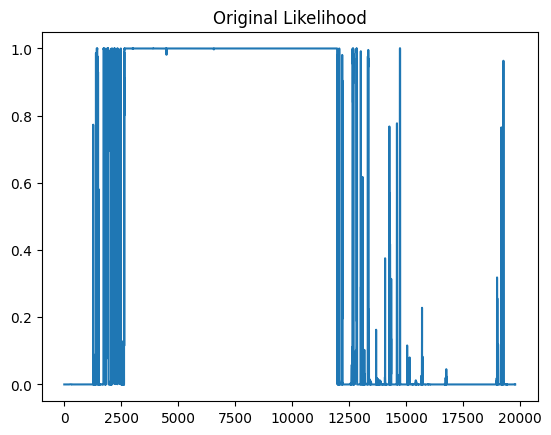

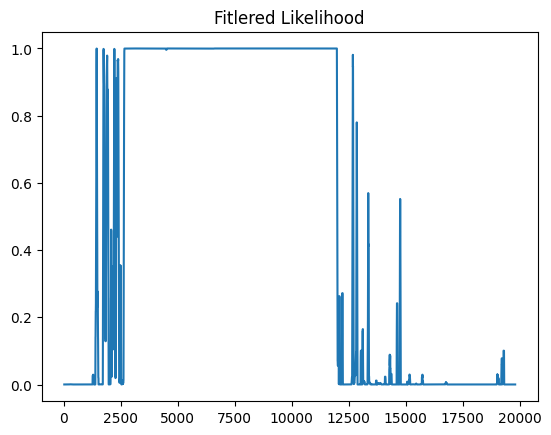

{1: [83560, 92997]} 1
HEAD:           0
0  0.536347
1  0.536347
2  0.534516
3  0.534211
4  0.533905
HEAD:     0
0 NaN
1 NaN
2 NaN
3 NaN
4 NaN
HEAD:       0
24  0.0
25  0.0
26  0.0
27  0.0
28  0.0


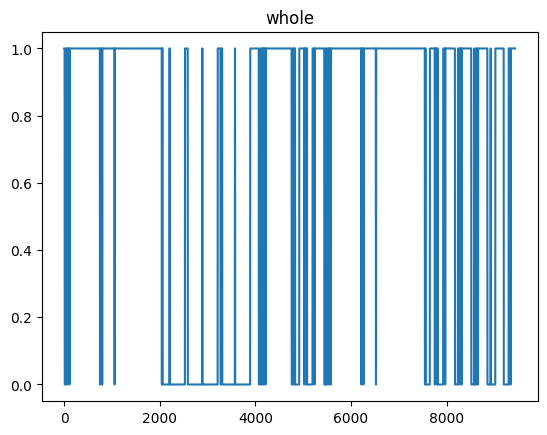

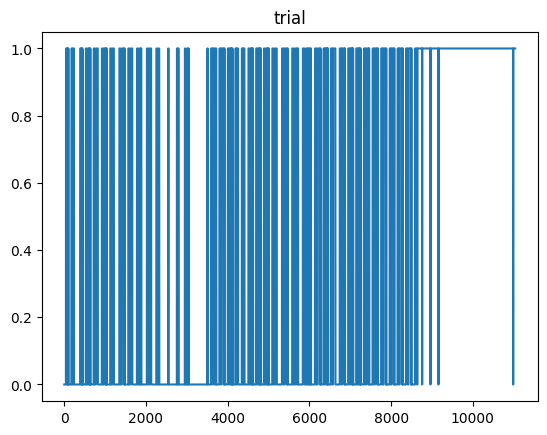

Original length of Pointgrey Signal: 9437
Original length of ADC Signal: 11039
Length of Point Grey Signal: 11039
Length of shifted ADC signal: 11039


<ipython-input-15-38f2e1b47fab>:73: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  axes[1].stem(shift_positions, correlate_result, use_line_collection=True, label="Cross-correlation of Point Grey and ADC")


Length of Point Grey Signal: 11039
Length of trimmed shifted ADC signal: 11039
-1602
Correct trial index start: 83467
Correct trial index end: 94506
Correct trial length: 11039
00:46:24.639750
00:52:32.768125
Input #0, avi, from '/content/drive/My Drive/RGS14/PointGreyVideo2018-07-30T11_24_12downsampled.avi':
  Metadata:
    software        : Lavf58.76.100
  Duration: 07:16:03.90, start: 0.000000, bitrate: 206 kb/s
  Stream #0:0: Video: mpeg4 (Simple Profile) (FMP4 / 0x34504D46), yuv420p, 325x256 [SAR 1:1 DAR 325:256], 200 kb/s, SAR 41984:41925 DAR 164:129, 30 fps, 30 tbr, 30 tbn, 30 tbc
File '/content/drive/My Drive/RGS14//PointGreyVideo2018-07-30T11_24_12downsampled-TRIM.avi' already exists. Overwrite? [y/N] y
Output #0, avi, to '/content/drive/My Drive/RGS14//PointGreyVideo2018-07-30T11_24_12downsampled-TRIM.avi':
  Metadata:
    software        : Lavf58.76.100
    ISFT            : Lavf58.76.100
  Stream #0:0: Video: mpeg4 (Simple Profile) (FMP4 / 0x34504D46), yuv420p, 325x256 [SAR

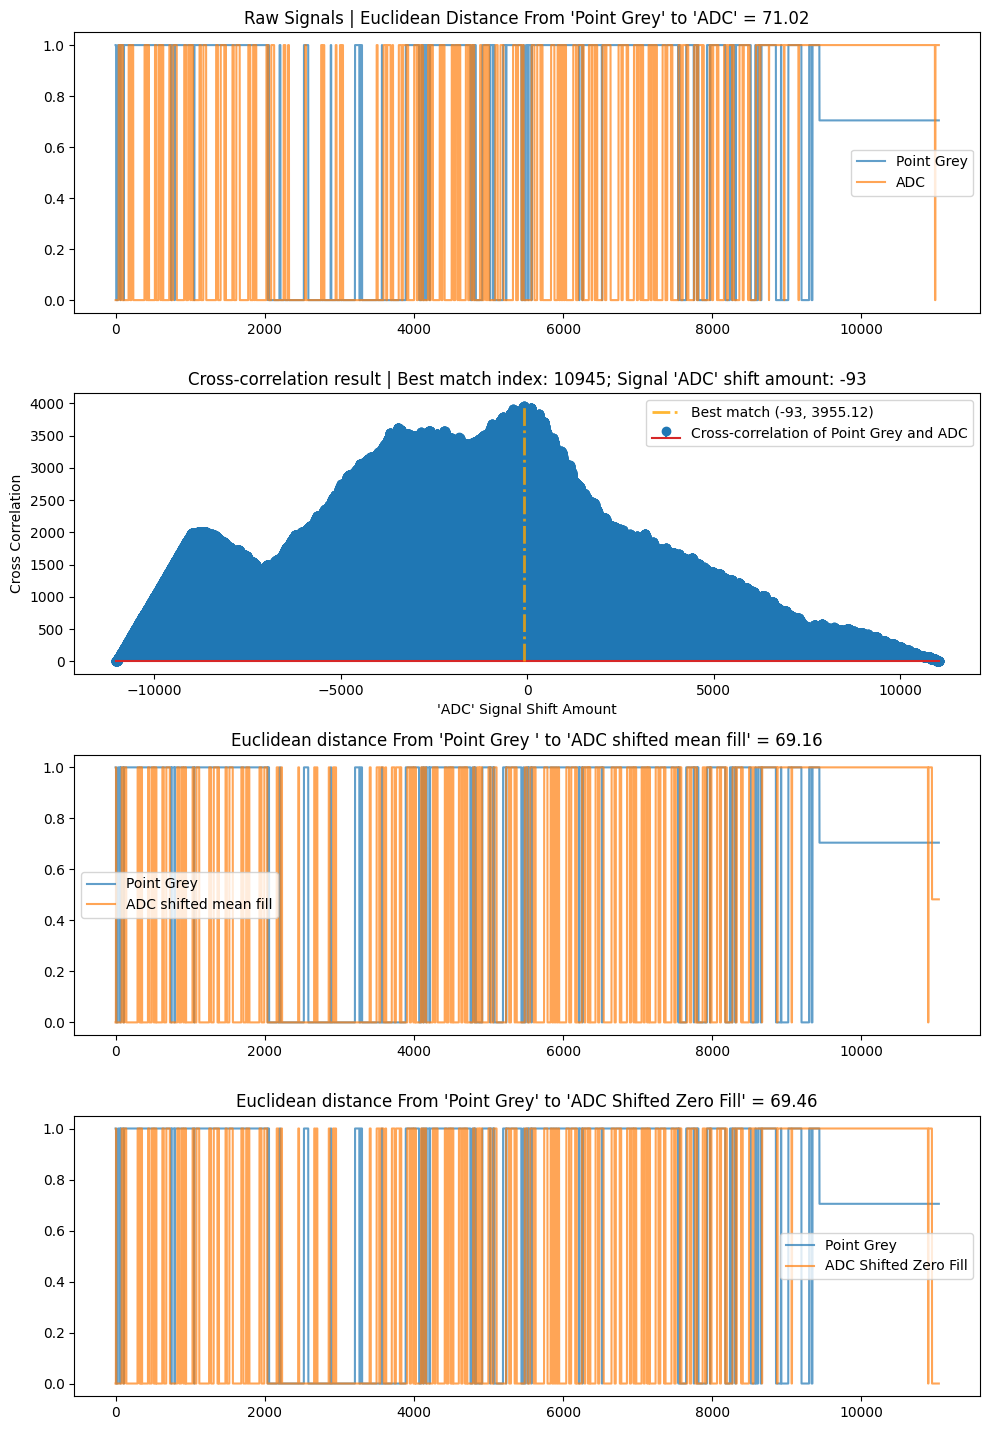

In [ ]:
whole, trial = extraction_t(file_path = file_path,
                            date_serial = date_serial,
                            ADC = ADC,
                            ADC_loc = '',
                            Video_type = VideoType,
                            ProjectFolderName = ProjectFolderName,
                            DLCscorer = DLCscorer,
                            path_config_file = path_config_file,
                            cut_analyze = cut_analyze)


# Analysis and Post Processing

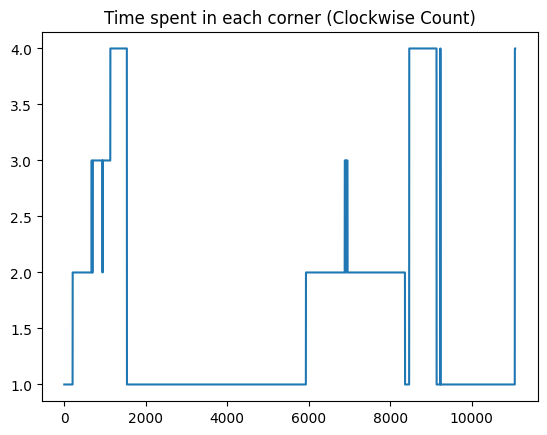

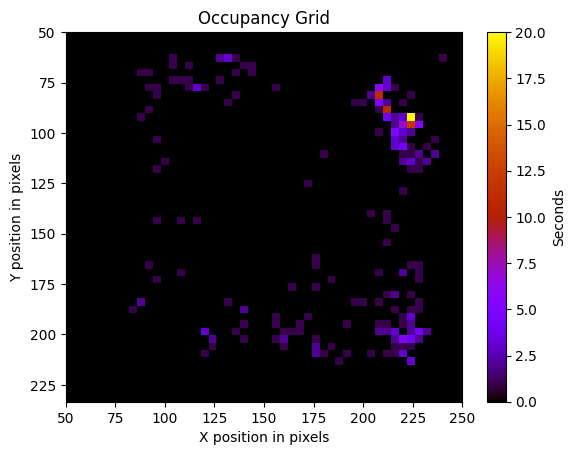

(50, 50)


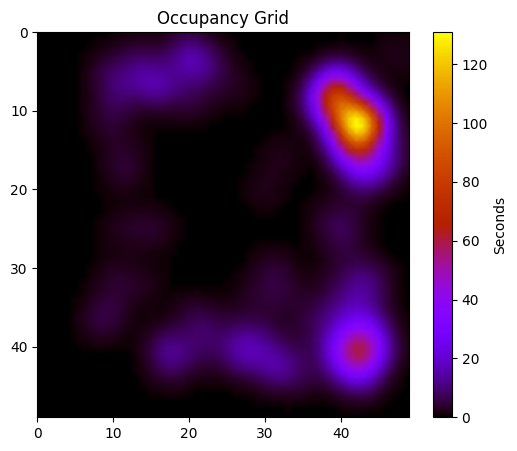

In [ ]:
import deeplabcut

def main_deeplabcut(directory,
                    config,
                    videoType,
                    save_csv,
                    create_labeled,
                    create_plots,
                    analyze_skeleton,
                    corner_inspection,
                    head_dir,
                    occupancy_map,
                    calculate_speed,
                    DLC_scorer,
                    date_serial,
                    x,
                    y):
    """Deeplabcut code to analyze all videos in a directory and create
    the desired data (plots, labeled video, and skeleton).

    Keyword arguments:
    directory -- path to the directory
    config -- path to the config file
    videoType -- string with video type (.avi)
    save_csv -- bool value (True if you need to create CSV files rather than h5)
    create_labeled -- bool value (True if you want to create a labeled video)
    create_plots -- bool value (True if you want to create plots of the trajectory, likelihood, x and y coordinates)
    analyze_skeleton -- bool value (True if you want to create the skeleton files)
    """
    # Analyze videos
    # deeplabcut.analyze_videos(config, [directory], save_as_csv=save_csv)

    if create_plots:
        # Plot trajectory
        deeplabcut.plot_trajectories(config, [directory])

    if create_labeled:
        # Create labeled video
        deeplabcut.create_labeled_video(config, [directory], videotype=videoType, draw_skeleton=True)

    if analyze_skeleton:
        # Analyze skeleton
        deeplabcut.analyzeskeleton(config, [directory], videotype=videoType, shuffle=1, trainingsetindex=0, save_as_csv=save_csv, destfolder=None)

    if corner_inspection:
        # Time spent in each corner (X and Y are the center point in the arena, modify if necessary)
        corner_inspect(directory, date_serial, DLCscorer = DLC_scorer, X = x, Y = y)

    if head_dir:
        # Plotting head direction in the whole trial
        head_direction(directory, date_serial, DLCscorer = DLC_scorer)

    if occupancy_map:
        # Plotting occupancy grid
        occupancy_grid(directory, date_serial, DLCscorer = DLC_scorer, bin = 50, max = 100)

    if calculate_speed:
        calculateSpeed(directory, DLCscorer, 0.999, date_serial = date_serial, VideoType = videoType)


main_deeplabcut(directory = path_trial, config = path_config_file, videoType = VideoType,
                save_csv = save_csv, create_labeled = create_labeled, create_plots = create_plots,
                analyze_skeleton = analyze_skeleton, corner_inspection = corner_inspection,
                head_dir = head_dir,
                occupancy_map = occupancy_map,
                calculate_speed = calculate_speed,
                DLC_scorer = DLCscorer,
                date_serial = date_serial,
                x = x,
                y = y)


# Average distance between bodyparts

In [ ]:
# set variables
video='/content/drive/My Drive/RGS14/trimmed/PointGreyVideo2018-07-30T11_24_12downsampled-TRIM.avi'
DLCscorer='DLC_resnet50_newtestJul11shuffle1_150000'
file = video.replace('.avi', DLCscorer+'.h5')
#loading output of DLC
Dataframe = pd.read_hdf(file)
def calculateDistance_body(row):
  """   calculate the distance between 2 x and y coordinates
          Keyword arguments:
          row -- row of dataframe with x and y coordinates of 2 bodyparts

  """
  x2 = row[2]
  x1 = row[0]
  y2 = row[3]
  y1 = row[1]
  dist = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
  return dist

#Getting data of the head
side_r_x = Dataframe['DLC_resnet50_newtestJul11shuffle1_150000']['Sideright']['x']
side_r_y = Dataframe['DLC_resnet50_newtestJul11shuffle1_150000']['Sideright']['y']
side_l_x = Dataframe['DLC_resnet50_newtestJul11shuffle1_150000']['Tailbase']['x']
side_l_y = Dataframe['DLC_resnet50_newtestJul11shuffle1_150000']['Tailbase']['y']

# add two datafarmes together
new_DF = side_r_x.to_frame().join(side_r_y)
new_DF = new_DF.join(side_l_x, rsuffix='_sideleft')
new_DF = new_DF.join(side_l_y, rsuffix='_sideleft')

# calculate distance between two points
new_DF['distance'] = 0
new_DF['distance'] = new_DF.apply (lambda row: calculateDistance_body(row), axis=1)

# calculate the mean
print(new_DF.head())
print(new_DF['distance'].mean())

            x          y  x_sideleft  y_sideleft   distance
0  217.692261  98.181648  225.010223  122.282249  25.187131
1  217.690262  98.174118  225.046066  122.306374  25.228429
2  217.757812  98.065308  225.059875  122.261368  25.273889
3  217.789886  97.823036  225.032822  122.277054  25.504099
4  217.758698  97.904228  225.043579  122.295555  25.455968
24.971818462267095


# TESTING WITH NEURONS

In [ ]:
Trial1_times = timestamp_extraction(file_path = '/content/drive/My Drive/RGS14/',
                     date_serial = '2018-07-30T11_24_12',
                     ADC =  '1' ,
                     ADC_loc = '')

In [ ]:
from pandas import DataFrame
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.stats import gaussian_kde
import scipy.io as sio
from scipy.ndimage import gaussian_filter
import os
import sys
import re
#import deeplabcut

def Neuron_Analysis(ADC_loc, kmeans, path, df_xy, n_clusters, num, Trial1_times, Rat_n, SD_n):
    """ Analysis of the neurons in a trial by matching the timestamps with spatial data.
        With the use of kmeans, 6 clusters are created over which the analysis will take place.

        Keyword arguments:
        ADC_loc -- string containing "trial#"
        kmeans -- The kmeans algorithm created earlier on the first trial data
        path -- Path to where all files are located
        df_xy -- dataframe with x,y coordinates and likelihood per frame
        n_clusters -- amount of clusters used in the kmeans algorithm
        num -- number of the current trial
        Trial1_times -- dataframe with the index and timestamps of the trial
        Rat_n -- rat number
        SD_n -- study day number
    """

    # Loading .mat file
    mat = 'R{}SD{}_{}'.format(Rat_n, SD_n, ADC_loc)
    mat_fname = path + ADC_loc + '/R{}SD{}_{}.mat'.format(Rat_n, SD_n, ADC_loc)
    mat_contents = sio.loadmat(mat_fname)

    # Process the data and perform analysis
    # ...

    return neur_dic, total_frame, amount_neurons

def make_circles(loc, ax, col, row):
    """ Makes 2 circles depicting the object placement for the right graph

    Keyword arguments:
    loc -- list of tuples containing the location of the circle
    ax -- ax of the plot
    col -- column of the subplot
    row -- row of the subplot
    """
    # Draw circles on the plot
    for l in loc:
        c = plt.Circle(l, 30, color='black', fill=False)
        ax[row, col].add_patch(c)

def plot_neurons(neur_dic, amount):
    """ Plots the generated analysis in one big plot with 6 columns and as many rows as there are neurons plus 1,
        containing the cumulative activity over all neurons.
        Circles are drawn in the location of the object manually.

    Keyword arguments:
    neur_dic -- dictionary containing all neurons and their data per trial, as well as the cumulative.
    amount -- number of neurons
    """
    # Define the number of rows and columns for the plot
    rows, cols = amount + 1, 6

    # Define the coordinates for the object circles
    t_r = (225, 50)
    b_r = (225, 175)
    t_l = (125, 50)
    b_l = (125, 175)

    # Create the figure and axes for the subplots
    fig, ax = plt.subplots(rows, cols, sharex='col', sharey='row', figsize=(20, 40))
    fig.tight_layout()

    n = 0
    for row in range(rows):
        n = n + 1
        for col in range(cols):
            if n in neur_dic.keys():
                # Plot the data for each neuron
                # ...

                # Adaptations per col and row to add circles for objects and set the titles correctly
                if col == 0:
                    make_circles([b_l, t_l], ax, col, row)
                elif col == 1:
                    make_circles([b_l, t_r], ax, col, row)
                elif col == 2:
                    make_circles([b_l, t_r], ax, col, row)
                elif col == 3:
                    make_circles([b_l, t_l], ax, col, row)
                elif col == 4:
                    make_circles([b_r, b_l], ax, col, row)
                elif col == 5:
                    ax[row, col].set_title('cummulative activity')

                if row == amount:
                    ax[row, col].set_title('c activity over trial {}'.format(col + 1))

    # Invert y-axis for the plots
    for i in range(rows):
        ax[i, 0].invert_yaxis()

    plt.show()

def create_tracking_subset(file):
    """ Creates the tracking subset to only contain the head and writes it to a CSV file.

    Keyword arguments:
    file -- .h5 file from deeplabcut analysis with its full path
    """
    # Read in the data from the file
    Dataframe = pd.read_hdf(file)

    # Extract the necessary columns for the head tracking
    df_x = Dataframe['DLC_resnet50_newtestJul11shuffle1_150000']['Head']['x'].to_frame()
    df_y = Dataframe['DLC_resnet50_newtestJul11shuffle1_150000']['Head']['y'].to_frame()
    df_l = Dataframe['DLC_resnet50_newtestJul11shuffle1_150000']['Head']['likelihood'].to_frame()

    # Combine the columns into a new DataFrame
    df_xy = df_x.join(df_y)
    df_xy = df_xy.join(df_l)

    # Write the DataFrame to a CSV file
    df_xy.to_csv('tracking_data.csv')

    return df_xy

def create_kmeans(df_xy, n_clusters):
    """ Creates a kmeans algorithm based on the x and y data in the dataframe with as many clusters as specified.

    Keyword arguments:
    df_xy -- dataframe with x, y, and likelihood columns
    n_clusters -- number of clusters
    """
    # Filter the data to contain only points within the desired range
    df = df_xy[(df_xy['x'].between(50, 275)) & (df_xy['y'].between(10, 210))]

    # Create the kmeans algorithm
    kmeans = KMeans(n_clusters=n_clusters).fit(df[['x', 'y']])
    return kmeans

def cummulative(neur_dic, total_frame, n_clusters):
    """ Adds together all trial spiking dataframes as well as the tracking dataset.
        By taking the total amount of spikes in one cluster and the total amount of datapoints in one cluster,
        the cumulative data is calculated.

    Keyword arguments:
    neur_dic -- dictionary with all neurons and their spiking dataframes per trial, as well as the cumulative.
    total_frame -- dataframe with the tracking data and its clusters
    n_clusters -- number of clusters
    """
    # Add all total frames together
    new_Total = None
    for f in range(len(total_frame) - 1):
        if f == 0:
            new_Total = total_frame[f]
        new_Total = new_Total.add(total_frame[f + 1], fill_value=0)

    for k, v in neur_dic.items():
        # Concatenate the dataframes for each trial
        concated = pd.concat(v)
        neuron_frame = concated['clusters'].value_counts()
        neuron_frame = pd.concat([neuron_frame, new_Total], axis=1)
        neuron_frame['Result'] = neuron_frame['clusters'] / neuron_frame['cluster']
        concated['value'] = np.NaN
        for i in range(n_clusters):
            concated.loc[concated.clusters == i, 'value'] = neuron_frame.iloc[i]['Result']
        v.append(concated)

    # Add the cumulative data to the last item in the dictionary
    keys = list(neur_dic.keys())
    neur_dic[int(keys[-1]) + 1] = []
    cummulative_list = []

    # Add all trial spiking frames together
    for i in range(5):
        for k, v in neur_dic.items():
            if len(v) - 2 >= i:
                cummulative_list.append(v[i])
        concated_list = pd.concat(cummulative_list)
        neuron_frame = concated_list['clusters'].value_counts()
        neuron_frame = pd.concat([neuron_frame, total_frame[i]], axis=1)
        neuron_frame['Result'] = neuron_frame['clusters'] / neuron_frame['cluster']
        concated_list['value'] = np.NaN
        for i in range(n_clusters):
            concated_list.loc[concated_list.clusters == i, 'value'] = neuron_frame.iloc[i]['Result']
        neur_dic[list(neur_dic.keys())[-1]].append(concated_list)
        cummulative_list = []

    return neur_dic


In [ ]:
ADC_loc = '100_ADC'+'1'+'_0.continuous'
kmeans = 3
df_xy = '/content/drive/My Drive/RGS14/trimmed/PointGreyVideo2018-07-30T11_24_12downsampled-TRIMDLC_resnet50_newtestJul11shuffle1_150000.csv'
n_clusters = 6
path = '/content/drive/My Drive/RGS14/'
num = 1
Rat_n = 1
SD_n = 1
Trial1_times = 'PointGreyTimestamps2018-07-30T11_24_12.csv'
Neuron_Analysis(ADC_loc, kmeans, path, df_xy, n_clusters, num, Trial1_times, Rat_n, SD_n)